In [1]:
# base and metaprogramming imports
from __future__ import annotations

import datetime
import os
import shutil
import sys
import itertools as it
import pprint as pp
from typing import Optional
import warnings
import glob
import copy
import functools as ft

# analysis imports
import h5py
import numpy as np
import pandas as pd
import pandas
import yaml
from pandas.api.types import CategoricalDtype
import scipy
import scipy.ndimage
import skimage as ski
from tifffile.tifffile import imwrite

import ants
try:
    ants.from_numpy
except Exception:
    warnings.warn(f'`ants` module import failed.')
    ants = None
else:
    print('`ants` installed and imported successfully.')

# visualization and plotting imports
import napari
import napari.settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# caiman imports
import bokeh.plotting as bpl
import cv2
try:
    cv2.setNumThreads(0)
except Exception:
    pass
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()

# ipynb-specific imports
try:
    import ipynbname
except Exception as e:
    warnings.warn(f'`ipynbname` module import failed with error: {e!r}')
    ipynbname = None
    
if ipynbname is not None:
    _file = ipynbname.path()
else:
    # manually set the full path to the current notebook below if `ipynbname` 
    # import fails
    raise RuntimeError('`ipynbname` import failed. Please set the `_file`'
                       'variable manually.')
    _file = ''
    
jobs_dir = os.path.split(_file)[0]
sources_dir = os.path.abspath(os.path.join(jobs_dir, '..'))
repo_dir = os.path.abspath(os.path.join(sources_dir, '..'))
config_dir = os.path.abspath(os.path.join(repo_dir, 'configs'))

# add sources directory to path
if sources_dir not in sys.path:
    sys.path.append(sources_dir)

# local imports
import c_swain_python_utils as csutils
from utilities import *
import imaging_dataset as imd
import prairie_view_imports as pvi

_basename = os.path.basename(_file)
_name = csutils.no_ext_basename(_file)

`ants` installed and imported successfully.


Loading BokehJS ...

In [2]:
[fn for fn in mpl.font_manager.findSystemFonts()
 if 'helveticaltpro' in fn.lower()]

['C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-BoldOblique.otf',
 'C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Black.otf',
 'C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Light.otf',
 'C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Bold.otf',
 'C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-BlackOblique.otf',
 'C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Oblique.otf',
 'C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-LightOblique.otf',
 'C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Roman.otf']

In [3]:
mpl.font_manager.fontManager.addfont('C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Black.otf')
mpl.font_manager.fontManager.findfont('Helvetica LT Pro Black')

findfont: Font family ['Helvetica LT Pro Black'] not found. Falling back to DejaVu Sans.


'I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'

In [4]:
mpl.font_manager.fontManager.addfont('C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Roman.otf')
mpl.font_manager.fontManager.findfont('Helvetica LT Pro')

'C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Roman.otf'

In [5]:
# plotting defaults
mpl.font_manager.fontManager.addfont('C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Black.otf')
mpl.font_manager.fontManager.addfont('C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Bold.otf')
mpl.font_manager.fontManager.addfont('C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Roman.otf')
sns.set_style(
    'ticks',
    {'font.sans-serif': ['Helvetica LT Pro', ],
     'mathtext.fontset': ['cm',],
     'axes.linewidth': 2,
     }
)
axes_lw = 2
mpl.rcParams['axes.linewidth'] = axes_lw
mpl.rcParams['xtick.major.width'] = axes_lw
mpl.rcParams['xtick.minor.width'] = axes_lw
mpl.rcParams['ytick.major.width'] = axes_lw
mpl.rcParams['ytick.minor.width'] = axes_lw
mpl.rcParams['axes.facecolor'] = 'none'
mpl.rcParams['figure.frameon'] = False
mpl.rcParams['figure.facecolor'] = 'none'
mpl.rcParams['figure.edgecolor'] = 'none'

In [6]:
# logging setup
log = csutils.get_logger(_name)

debug_mode = False
default_window_level = 'debug'

log_path = os.path.join(sources_dir, '..', 'logs', f'{_basename}.log')
csutils.apply_standard_logging_config(
    file_path=log_path,
    window_level='debug' if debug_mode else default_window_level,
    window_format='debug' if debug_mode else 'default')

## Load the Configs and Dataset Infos

In [7]:
config_fname_list = [
    'cs-ii-31_config.yml',]

config_list: list[ZMIAConfig] = []
for config_fname in config_fname_list:
    config_list.append(
        ZMIAConfig(os.path.join(config_dir, config_fname))) 
    
    if config_list[-1].output_directory:
        csutils.touchdir(config_list[-1].output_directory)

all_dataset_infos = sum([c.dataset_list for c in config_list], [])

all_2p_live_dataset_infos = [
    di for di in all_dataset_infos                    
    if (di.type == 'two-photon' and di.run_id is not None)]

# all_2p_live_dataset_infos = all_2p_live_dataset_infos[1:2] # subset for testing

num_matched_datasets = len(all_2p_live_dataset_infos)
log.info('Matched {:d} live 2p dataset(s).', num_matched_datasets)

local-nb_cs-ii-31_dye-test-analysis (  21): INFO : Matched 11 live 2p dataset(s).


In [8]:
# store some additional metadata by full path
dsi: ZMIADatasetInfo
misc_metadata_dict: dict[str, dict] = {}
for dsi in all_2p_live_dataset_infos:
    misc_metadata_dict[dsi.full_path] = {
        'dataset_info': dsi,
        'experiment_id': dsi.data['experiment-id'],
        'run_id': dsi.run_id
    }
    
misc_metadata_dict

{'G:\\c_swain\\zf_correlative_microscopy\\raw_data\\cs-ii-31_2-photon_20231012\\TSeries-10122023-1241-126': {'dataset_info': {'experiment-id': 'cs-ii-31', 'fish-id': None, 'fish-genotype': None, 'datetime-stamp': '20231012-1241', 'type': 'two-photon', 'path': 'cs-ii-31_2-photon_20231012\\TSeries-10122023-1241-126', 'name': 'ref-cs-ii-31_dye-test_run-126_2p-t', 'run-id': 126},
  'experiment_id': 'cs-ii-31',
  'run_id': 126},
 'G:\\c_swain\\zf_correlative_microscopy\\raw_data\\cs-ii-31_2-photon_20231012\\TSeries-10122023-1241-127': {'dataset_info': {'experiment-id': 'cs-ii-31', 'fish-id': None, 'fish-genotype': None, 'datetime-stamp': '20231012-1241', 'type': 'two-photon', 'path': 'cs-ii-31_2-photon_20231012\\TSeries-10122023-1241-127', 'name': 'ref-cs-ii-31_dye-test_run-127_2p-t', 'run-id': 127},
  'experiment_id': 'cs-ii-31',
  'run_id': 127},
 'G:\\c_swain\\zf_correlative_microscopy\\raw_data\\cs-ii-31_2-photon_20231012\\TSeries-10122023-1241-128': {'dataset_info': {'experiment-id': '

In [9]:
# RESET TO FALSE TO PREVENT EXPENSIVE RELOADING OF IMAGING DATASETS
force_image_data_dict_creation = False  # <<<<<<<<<<<<< FALSE <<<<<

if 'imaging_dataset_dict' in locals() and not force_image_data_dict_creation:
    log.warning('`imaging_dataset_dict` already exists. Skipping creation...')
else:
    imaging_dataset_dict = {}

In [10]:
for i, dsi in enumerate(all_2p_live_dataset_infos):
    full_path = dsi.full_path
    if full_path in imaging_dataset_dict:
        log.warning(
            'Dataset {:d} of {:d} already loaded into dict:\n\t"{:s}".'
            '\n\tSkipping...',
            i + 1, num_matched_datasets, full_path)
        continue
    
    log.info('Loading dataset {:d} of {:d}:\n\t"{:s}".',
             i + 1, num_matched_datasets, full_path)
    
    try:
        live_imds = imd.ImagingDataset.from_dataset_info(dsi)
    except Exception as e:
        log.error(
            'Failed to load dataset:\n\t"{:s}".',
            full_path, exc_info=e)
        continue
    else:
        imaging_dataset_dict[full_path] = live_imds

local-nb_cs-ii-31_dye-test-analysis (  10): INFO : Loading dataset 1 of 11:
	"G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-31_2-photon_20231012\TSeries-10122023-1241-126".
prairie_view_imports (2751): INFO : Loading dataset (two-photon-ref-cs-ii-31_dye-test_run-126_2p-t) from config cs-ii-31.
prairie_view_imports (1534): INFO : Attempting to load dataset from cache.
prairie_view_imports (1541): DEBUG : Cache-file loaded.
prairie_view_imports (1547): DEBUG : Initializing metadata from cache-file.
prairie_view_imports (1551): INFO : Loading of dataset from cache was successful.
prairie_view_imports (1565): INFO : Loading in cached images.
prairie_view_imports (1573): INFO : Loading in of cached images is sucessful.
imaging_dataset (1063): INFO : Categorized PVDataset as PVDatasetCategory.T_SERIES
imaging_dataset (1070): INFO : Initializing ImagingDataset(s) from prairie view dataset PVDataset(name='two-photon-ref-cs-ii-31_dye-test_run-126_2p-t', num_sequences=1)
imaging_dataset ( 

local-nb_cs-ii-31_dye-test-analysis (  16): ERROR : Failed to load dataset:
	"G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-31_2-photon_20231012\TSeries-10122023-1241-134".
Traceback (most recent call last):
  File "C:\Users\CorbanSwain\AppData\Local\Temp\ipykernel_32500\513396020.py", line 14, in <module>
    live_imds = imd.ImagingDataset.from_dataset_info(dsi)
  File "I:\CorbanSwain\repos\zmia\source\imaging_dataset.py", line 867, in from_dataset_info
    loader(
  File "I:\CorbanSwain\repos\zmia\source\prairie_view_imports.py", line 2755, in load_dataset
    return PVDataset(dataset_info.full_path, **kwargs)
  File "I:\CorbanSwain\repos\zmia\source\prairie_view_imports.py", line 1386, in __init__
    self._init_from_path(path,
  File "I:\CorbanSwain\repos\zmia\source\prairie_view_imports.py", line 1485, in _init_from_path
    init_function(**init_func_kwargs)
  File "I:\CorbanSwain\repos\zmia\source\prairie_view_imports.py", line 1525, in _init_from_xml
    self.cache_to_disk

local-nb_cs-ii-31_dye-test-analysis (  10): INFO : Loading dataset 10 of 11:
	"G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-31_2-photon_20231012\TSeries-10122023-1241-135".
prairie_view_imports (2751): INFO : Loading dataset (two-photon-ref-cs-ii-31_dye-test_run-135_2p-t) from config cs-ii-31.
prairie_view_imports (1492): INFO : Importing dataset metadata from xml.
prairie_view_imports (1494): DEBUG : Loading the top-level dataset metadata.
prairie_view_imports (1515): DEBUG : Loading metadata for all sequences in the dataset.
prairie_view_imports (1589): DEBUG : Sifting the dataset's metadata; this may take some time.
prairie_view_imports (1593): DEBUG : Creating a template metadata set.
prairie_view_imports (1598): DEBUG : Initializing unique metadata for all _PVData objects.
prairie_view_imports (1601): DEBUG : Unique metadata initialization complete; all dataset metadata is successfully sifted.
prairie_view_imports (1622): INFO : Caching dataset to disk.
prairie_view_imports

local-nb_cs-ii-31_dye-test-analysis (  16): ERROR : Failed to load dataset:
	"G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-31_2-photon_20231012\TSeries-10122023-1241-135".
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "I:\CorbanSwain\repos\zmia\envs\zmia-env-everything-3.10-v3\lib\multiprocessing\pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "I:\CorbanSwain\repos\zmia\source\utilities.py", line 152, in imread
    return ski.io.imread(*args, plugin=SKIMAGE_IO_PLUGIN, **kwargs)
  File "I:\CorbanSwain\repos\zmia\envs\zmia-env-everything-3.10-v3\lib\site-packages\skimage\io\_io.py", line 53, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "I:\CorbanSwain\repos\zmia\envs\zmia-env-everything-3.10-v3\lib\site-packages\skimage\io\manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)
  File "I:\CorbanSwain\repos\zmia\envs\zmia-env-everything-3.10-v3\lib\sit

local-nb_cs-ii-31_dye-test-analysis (  10): INFO : Loading dataset 11 of 11:
	"G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-31_2-photon_20231012\TSeries-10122023-1241-136".
prairie_view_imports (2751): INFO : Loading dataset (two-photon-ref-cs-ii-31_dye-test_run-136_2p-t) from config cs-ii-31.
prairie_view_imports (1534): INFO : Attempting to load dataset from cache.
prairie_view_imports (1541): DEBUG : Cache-file loaded.
prairie_view_imports (1547): DEBUG : Initializing metadata from cache-file.
prairie_view_imports (1551): INFO : Loading of dataset from cache was successful.
prairie_view_imports (1565): INFO : Loading in cached images.
prairie_view_imports (1573): INFO : Loading in of cached images is sucessful.
imaging_dataset (1063): INFO : Categorized PVDataset as PVDatasetCategory.Z_STACK_IMAGE|TZ_SERIES_IMAGE|MULTI_SEQUENCE
imaging_dataset (1070): INFO : Initializing ImagingDataset(s) from prairie view dataset PVDataset(name='two-photon-ref-cs-ii-31_dye-test_run-136_2p-t'

In [13]:
napari.settings.get_settings().application.ipy_interactive = True
viewer = napari.Viewer()
for full_path, imds in imaging_dataset_dict.items():
    log.info('Adding dataset "{}" to viewer.', imds.name)
    log.info(f'{imds.shape_dict = }')    
    viewer.add_image(imds.get_image_data(), name=imds.name)
# napari.run()

in_n_out (1093): DEBUG : Registering provider of <class 'napari.viewer.Viewer'>: <function _provide_viewer at 0x000001A084C26C20> (weight: 0, subclassable: True)
in_n_out (1093): DEBUG : Registering provider of <class 'napari.layers.base.base.Layer'>: <function _provide_active_layer at 0x000001A084C26B90> (weight: 0, subclassable: True)
in_n_out (1093): DEBUG : Registering provider of <class 'napari.components.layerlist.LayerList'>: <function _provide_active_layer_list at 0x000001A084C26B00> (weight: 0, subclassable: True)
in_n_out (1093): DEBUG : Registering processor of napari.types.LayerDataTuple: <function _add_layer_data_tuples_to_viewer at 0x000001A084C26D40> (weight: 0, subclassable: False)
in_n_out (1093): DEBUG : Registering processor of typing.List[napari.types.LayerDataTuple]: <function _add_layer_data_tuples_to_viewer at 0x000001A084C26D40> (weight: 0, subclassable: False)
in_n_out (1093): DEBUG : Registering processor of <class 'napari.layers.base.base.Layer'>: <function _

In [13]:
# 3: good, 2: OK, 1: not usable
run_scores_dict = {
    127: 1,
    126: 1,
    128: 3,
    129: 3,
    130: 3,
    131: 2,
    132: 3,
    133: 3,
    136: 1
}

In [14]:
LAYER_NAMES = (
    'LEFT-STIM (TOP)',
    'MIDDLE-STIM',
    'RIGHT-STIM (BOTTOM)',
    'LEFT-OE (TOP)',
    'RIGHT-OE (BOTTOM)',
    'BACKGROUND')


In [15]:
napari.settings.get_settings().application.ipy_interactive = False

# reset to False to prevent re-creating region selections
force_recreate_region_selections = False  # <<<<<<<<<<<<< FALSE <<<<<

if ('region_selection_dict' in locals()) and (not force_recreate_region_selections):
    log.info('`region_selection_dict` already exists. Skipping creation...')
    region_selection_dict = region_selection_dict
else:
    region_selection_dict: dict[str, np.ndarray] = dict()


for full_path, imds in imaging_dataset_dict.items():
    dsi = misc_metadata_dict[full_path]['dataset_info']
    run_id = dsi.run_id
    experiment_id = dsi.data['experiment-id']
    output_dir = dsi.config.output_directory
    
    if run_id in run_scores_dict:
        score = run_scores_dict[run_id]
        log.info(f'Setting score for run {run_id} to {score}.')
        misc_metadata_dict[full_path]['score'] = score
    else:
        score = 0
        
    if score < 2:
        log.info(f'Dropping dataset "{imds.name}" from analysis.')
        continue
        
    region_selection_dir = os.path.join(output_dir, 'region_selections')
    csutils.touchdir(region_selection_dir)
    region_selection_path = os.path.join(
        region_selection_dir, f'{experiment_id}_run-{run_id}.pkl.npy')
    
    if full_path in region_selection_dict:
        log.info(f'Region selection already exists for "{imds.name}". Skipping...')
        continue
    
    if os.path.exists(region_selection_path):
        region_selection = np.load(region_selection_path)        
        region_selection_dict[full_path] = region_selection
        log.info(f'Loaded region selection for "{imds.name}" from "{region_selection_path}".')
        continue
        
    # FIXME - this is a temporary hack to make sure i dont run this
    raise RuntimeError(f'TEMP - Region selection not found for "{imds.name}".')
        
    image_data = imds.get_image_data()
    image_data_mean = np.mean(image_data, axis=0)
    
    selection_arr = np.zeros_like(image_data_mean, dtype=int)
    
    viewer = napari.Viewer()
    viewer.add_image(image_data, name=dsi.name)
    viewer.add_image(image_data_mean, name=f'MEAN_{dsi.name}')   
    for ln in LAYER_NAMES:
        viewer.add_labels(
            selection_arr.copy(), 
            name=ln)
    napari.run()
    
    for i, ln in enumerate(LAYER_NAMES):
        selection_arr[viewer.layers[ln].data == 1] = i + 1
    
    log.info(f'Saving region selection for "{imds.name}" to "{region_selection_path}".')
    np.save(region_selection_path, selection_arr)
    
    region_selection_dict[full_path] = selection_arr
    

local-nb_cs-ii-31_dye-test-analysis (  21): INFO : Setting score for run 126 to 1.
local-nb_cs-ii-31_dye-test-analysis (  27): INFO : Dropping dataset "two-photon-ref-cs-ii-31_dye-test_run-126_2p-t" from analysis.
local-nb_cs-ii-31_dye-test-analysis (  21): INFO : Setting score for run 127 to 1.
local-nb_cs-ii-31_dye-test-analysis (  27): INFO : Dropping dataset "two-photon-ref-cs-ii-31_dye-test_run-127_2p-t" from analysis.
local-nb_cs-ii-31_dye-test-analysis (  21): INFO : Setting score for run 128 to 3.
local-nb_cs-ii-31_dye-test-analysis (  42): INFO : Loaded region selection for "two-photon-ref-cs-ii-31_dye-test_run-128_2p-t" from "G:\c_swain\zf_correlative_microscopy\analyzed_and_generated_data\cs-ii-31_dye-test-outputs\region_selections\cs-ii-31_run-128.pkl.npy".
local-nb_cs-ii-31_dye-test-analysis (  21): INFO : Setting score for run 129 to 3.
local-nb_cs-ii-31_dye-test-analysis (  42): INFO : Loaded region selection for "two-photon-ref-cs-ii-31_dye-test_run-129_2p-t" from "G:\c

## Preview Region Selections

In [17]:
napari.settings.get_settings().application.ipy_interactive = False

for full_path, region_selection in region_selection_dict.items():
    dsi = misc_metadata_dict[full_path]['dataset_info']
    run_id = dsi.run_id
    
    if not run_id == 133:
        continue
    
    experiment_id = dsi.data['experiment-id']
    output_dir = dsi.config.output_directory
    
    image_data = imaging_dataset_dict[full_path].get_image_data()
    image_data_mean = np.mean(image_data, axis=0)
    
    viewer = napari.Viewer()
    viewer.add_image(image_data_mean, name=f'MEAN_{dsi.name}')
    viewer.add_labels(region_selection, name='REGION_SELECTION')
    # napari.run()
    

napari.loader (  69): DEBUG : ImageSlice.__init__
napari.loader (  69): DEBUG : ImageSlice.__init__
napari.loader (  69): DEBUG : ImageSlice.__init__
napari.loader (  69): DEBUG : ImageSlice.__init__
napari.loader (  69): DEBUG : ImageSlice.__init__
napari.loader (  69): DEBUG : ImageSlice.__init__


In [16]:
baseline_time_sec = 25
stim_end_time_sec = 300
timecourse_dfs: dict[str, pd.DataFrame] = {}
TIME_KEY = 'time'

for full_path, region_selection in region_selection_dict.items():
    dsi = misc_metadata_dict[full_path]['dataset_info']
    run_id = dsi.run_id
    experiment_id = dsi.data['experiment-id']
    output_dir = dsi.config.output_directory
    
    imds = imaging_dataset_dict[full_path]
    image_data = imds.get_image_data()
    
    log.info(f'Processing dataset "{imds.name}" for region dye timecourses.')
    source_data: pvi.PVDataset = imds.source_data
    metadata_parser = pvi.PVMetadataInterpreter(source_data.metadata)
    
    log.info(f'{len(metadata_parser.relative_time) = }')
    log.info(f'{[len(x) for x in metadata_parser.relative_time] = }')
    coord = imd.CoordinateVector(vector=np.array(metadata_parser.relative_time[0]),
                                 unit='second')
    misc_metadata_dict[full_path]['time_coord'] = coord
    log.info(f'{coord = }')
    log.info(f'{coord.median_pitch = }')
    log.info(f'{imds.shape_dict = }')
    
    baseline_selection = coord.vector < baseline_time_sec
    no_end_selection = coord.vector < stim_end_time_sec
    
    output_timecourses: list[np.ndarray] = []
    
    for i, ln in enumerate(LAYER_NAMES):
        if ln == 'BACKGROUND':
            coeffs = np.array([0.05, 0.95])
        else:
            coeffs = np.array([0.6, 0.4])
            
        coeffs = coeffs / np.sum(coeffs)
        
        log.info(f'Processing layer "{ln}"')
        mask = region_selection == (i + 1)
        selected_data = image_data[:, mask].astype(float)
        mean_timecourse = np.mean(selected_data, axis=1)
        mean_timecourse = mean_timecourse[no_end_selection]
        baseline_val = (coeffs[0] * np.quantile(
            mean_timecourse[baseline_selection[no_end_selection]],
            q=.05,
            method='closest_observation')
            + coeffs[1] * np.min(mean_timecourse))
        norm_timecourse = mean_timecourse - baseline_val
        norm_timecourse = norm_timecourse / np.max(mean_timecourse) 
        output_timecourses.append(norm_timecourse)
    
    column_dict = {ln: tc for ln, tc in zip(LAYER_NAMES, output_timecourses)}
    column_dict[TIME_KEY] = coord.vector[no_end_selection]
    
    output_df = pd.DataFrame(column_dict)
    timecourse_dfs[full_path] = output_df

local-nb_cs-ii-31_dye-test-analysis (  15): INFO : Processing dataset "two-photon-ref-cs-ii-31_dye-test_run-128_2p-t" for region dye timecourses.
local-nb_cs-ii-31_dye-test-analysis (  19): INFO : len(metadata_parser.relative_time) = 1
local-nb_cs-ii-31_dye-test-analysis (  20): INFO : [len(x) for x in metadata_parser.relative_time] = [2338]
local-nb_cs-ii-31_dye-test-analysis (  24): INFO : coord = Coord([0.0, ...], len=2338, unit='second')
local-nb_cs-ii-31_dye-test-analysis (  25): INFO : coord.median_pitch = 0.1326144319999969
local-nb_cs-ii-31_dye-test-analysis (  26): INFO : imds.shape_dict = {Dim('time'): 2338, Dim('y'): 1024, Dim('x'): 1024}
local-nb_cs-ii-31_dye-test-analysis (  41): INFO : Processing layer "LEFT-STIM (TOP)"
local-nb_cs-ii-31_dye-test-analysis (  41): INFO : Processing layer "MIDDLE-STIM"
local-nb_cs-ii-31_dye-test-analysis (  41): INFO : Processing layer "RIGHT-STIM (BOTTOM)"
local-nb_cs-ii-31_dye-test-analysis (  41): INFO : Processing layer "LEFT-OE (TOP)"


In [17]:
output_df.head()

LEFT-STIM (TOP)  MIDDLE-STIM  RIGHT-STIM (BOTTOM)  LEFT-OE (TOP)  \
0         0.010656     0.005874             0.003878       0.039128   
1         0.007135     0.004193             0.002669       0.020185   
2         0.007110     0.003762             0.002880       0.019411   
3         0.007462     0.004074             0.002415       0.018863   
4         0.007282     0.003675             0.002645       0.021589   

   RIGHT-OE (BOTTOM)  BACKGROUND      time  
0           0.003184    0.095163  0.000000  
1           0.002117    0.070576  0.132614  
2           0.001990    0.066953  0.265229  
3           0.002064    0.067950  0.397843  
4           0.001907    0.067238  0.530458

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.
matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.
matplotlib.font_manager (1411): DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='sc

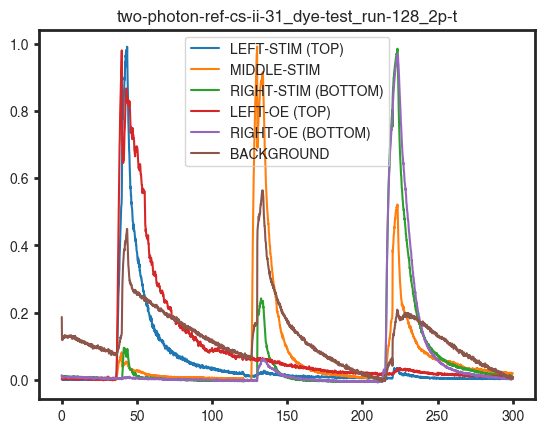

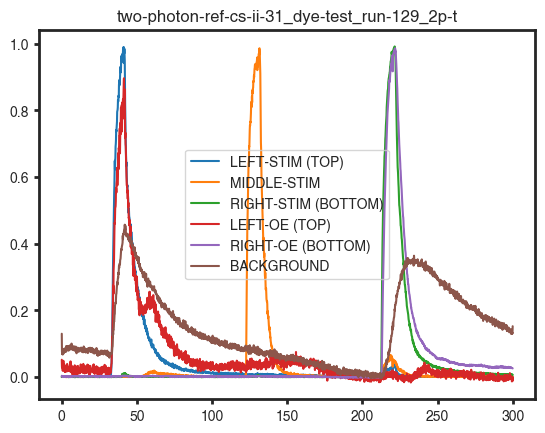

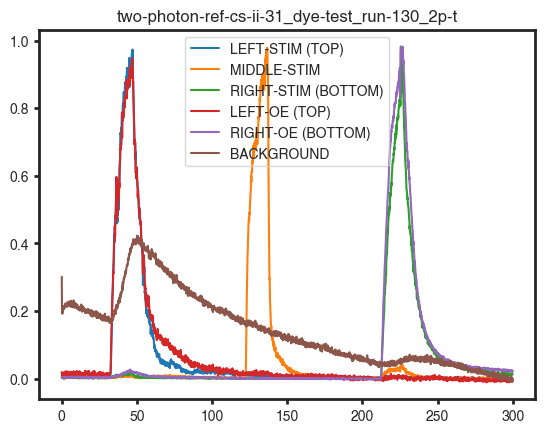

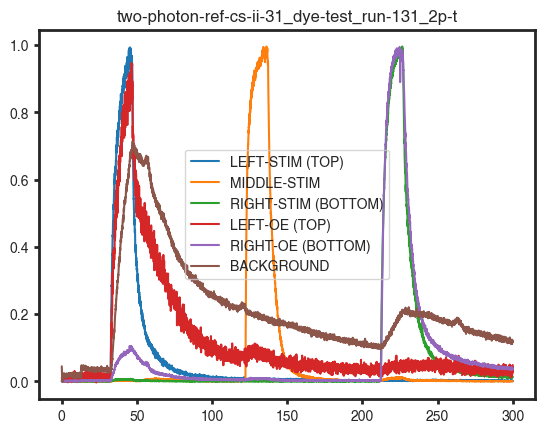

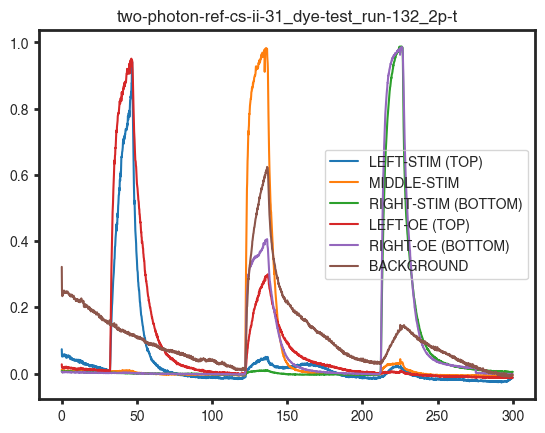

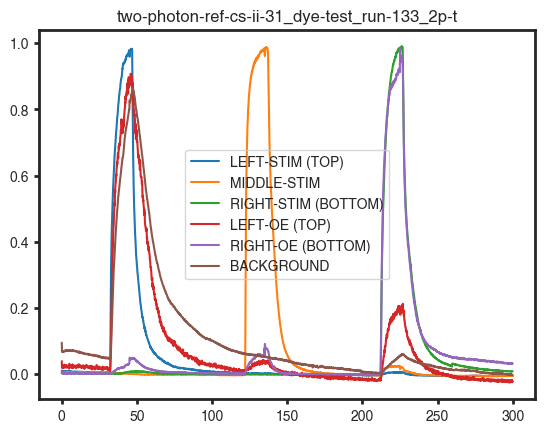

In [20]:
%matplotlib inline

for full_path, df in timecourse_dfs.items():
    fig = plt.figure()
    dsi = misc_metadata_dict[full_path]['dataset_info']
    
    for ln in LAYER_NAMES:
        if ln not in df.columns:
            continue
        plt.plot(df['time'], df[ln], label=ln)
        
    plt.title(dsi.name)
    plt.legend()
    plt.show()

## Resample all Timeseries to a common timebase

In [18]:
NYQUIST_FACTOR = 2.3

global_min_time_delta = None
for full_path, df in timecourse_dfs.items():
    time_data = df[TIME_KEY]
    min_time_delta = np.diff(time_data).min()
    
    if global_min_time_delta is None or min_time_delta < global_min_time_delta:
        global_min_time_delta = min_time_delta
        log.info(f'New global min time delta: {global_min_time_delta:.3f} seconds.')
        
new_timebase = np.arange(
    0, 
    (stim_end_time_sec - global_min_time_delta * 4), 
    global_min_time_delta / NYQUIST_FACTOR)

log.info(f'New timebase shape: {new_timebase.shape}')
log.info(f'New timebase range: [{new_timebase.min():.3f}, {new_timebase.max():.3f}] seconds.')

local-nb_cs-ii-31_dye-test-analysis (  10): INFO : New global min time delta: 0.133 seconds.
local-nb_cs-ii-31_dye-test-analysis (  10): INFO : New global min time delta: 0.133 seconds.
local-nb_cs-ii-31_dye-test-analysis (  10): INFO : New global min time delta: 0.066 seconds.
local-nb_cs-ii-31_dye-test-analysis (  17): INFO : New timebase shape: (10397,)
local-nb_cs-ii-31_dye-test-analysis (  18): INFO : New timebase range: [0.000, 299.709] seconds.


In [19]:
resampled_timecourse_dfs = dict()

EXPERIMENT_ID_CN = 'experiment_id'
RUN_ID_CN = 'run_id'

for full_path, df in timecourse_dfs.items():
    dsi: ZMIADatasetInfo = misc_metadata_dict[full_path]['dataset_info']
    log.info(f'Resampling timecourse for "{dsi.name}".')
    time_data = df[TIME_KEY]

    new_timecourse_dict = {
        TIME_KEY: new_timebase,
        EXPERIMENT_ID_CN: dsi.data['experiment-id'],
        RUN_ID_CN: dsi.run_id}
    
    for ln in LAYER_NAMES:
        if ln not in df.columns:
            continue
        new_timecourse_dict[ln] = np.interp(new_timebase, time_data, df[ln])
        
    new_df = pd.DataFrame(new_timecourse_dict)
    resampled_timecourse_dfs[full_path] = new_df
    
resample_timecourse_df = pd.concat(resampled_timecourse_dfs.values(), ignore_index=True)

local-nb_cs-ii-31_dye-test-analysis (   8): INFO : Resampling timecourse for "two-photon-ref-cs-ii-31_dye-test_run-128_2p-t".
local-nb_cs-ii-31_dye-test-analysis (   8): INFO : Resampling timecourse for "two-photon-ref-cs-ii-31_dye-test_run-129_2p-t".
local-nb_cs-ii-31_dye-test-analysis (   8): INFO : Resampling timecourse for "two-photon-ref-cs-ii-31_dye-test_run-130_2p-t".
local-nb_cs-ii-31_dye-test-analysis (   8): INFO : Resampling timecourse for "two-photon-ref-cs-ii-31_dye-test_run-131_2p-t".
local-nb_cs-ii-31_dye-test-analysis (   8): INFO : Resampling timecourse for "two-photon-ref-cs-ii-31_dye-test_run-132_2p-t".
local-nb_cs-ii-31_dye-test-analysis (   8): INFO : Resampling timecourse for "two-photon-ref-cs-ii-31_dye-test_run-133_2p-t".


In [21]:
log.info(f'{resample_timecourse_df.shape = }')

# preview first 100 rows
resample_timecourse_df.head()

local-nb_cs-ii-31_dye-test-analysis (   1): INFO : resample_timecourse_df.shape = (62382, 9)


time experiment_id  run_id  LEFT-STIM (TOP)  MIDDLE-STIM  \
0  0.000000      cs-ii-31     128         0.001326     0.008516   
1  0.028829      cs-ii-31     128         0.001232     0.008275   
2  0.057658      cs-ii-31     128         0.001139     0.008033   
3  0.086488      cs-ii-31     128         0.001045     0.007792   
4  0.115317      cs-ii-31     128         0.000951     0.007551   

   RIGHT-STIM (BOTTOM)  LEFT-OE (TOP)  RIGHT-OE (BOTTOM)  BACKGROUND  
0             0.012925       0.005686           0.013059    0.186989  
1             0.012438       0.004900           0.012058    0.173988  
2             0.011952       0.004115           0.011056    0.160988  
3             0.011466       0.003329           0.010055    0.147987  
4             0.010980       0.002543           0.009054    0.134986

## Setup Catagorical Data Types

In [22]:
FISH_WATER_NAME = 'fish-water'
DYE_NAME = 'dye'

ODOR_CATEGORICAL_DTYPE = pd.CategoricalDtype(
    categories=[
        FISH_WATER_NAME,
        DYE_NAME],
    ordered=False)

SIDE_CATEGORICAL_DTYPE = pd.CategoricalDtype(
    categories=[
        'left',
        'middle',
        'right',
        'background',
        'vacuum',
        'wash'],
    ordered=False)

REGION_CATEGORICAL_DTYPE = pd.CategoricalDtype(
    categories=[
        'needle_outlet',
        'olfactory_epithelium',
        'background'],
    ordered=False)

STIM_TYPE_CATEGORICAL_DTYPE = pd.CategoricalDtype(
    categories=[
        'equilibration',
        'break',
        'pulse'],
    ordered=False)

ODOR_LINE_TYPE = 'odor'
WASH_LINE_TYPE = 'wash'

LINE_TYPE_CATEGORICAL_DTYPE = pd.CategoricalDtype(
    categories=[
        ODOR_LINE_TYPE,
        WASH_LINE_TYPE],
    ordered=False)

ON_TRANSITION = 'on'
OFF_TRANSITION = 'off'
NO_TRANSITION = 'none'

TRANSITION_CATEGORICAL_DTYPE = pd.CategoricalDtype(
    categories=[
        ON_TRANSITION,
        OFF_TRANSITION,
        NO_TRANSITION],
    ordered=False)

## Fold Image Readout Timecourse Table

In [23]:
# continue folding table so there is only one column of timecourses
LOCATION_KEY = 'location_name'
FLUORESCENCE_KEY = 'relative_fluorescence'

folded_timecourse_df = resample_timecourse_df.melt(
    id_vars=[TIME_KEY, EXPERIMENT_ID_CN, RUN_ID_CN],
    var_name=LOCATION_KEY,
    value_name=FLUORESCENCE_KEY)

SIDE_KEY = 'side'
def get_side(region: str) -> str:
    if 'LEFT' in region:
        return 'left'
    elif 'RIGHT' in region:
        return 'right'
    elif 'MIDDLE' in region:
        return 'middle'
    else:
        return 'background'

REGION_KEY = 'region'
def get_region(region: str) -> str:
    if 'STIM' in region:
        return 'needle_outlet'
    elif 'OE' in region:
        return 'olfactory_epithelium'
    else:
        return 'background'


folded_timecourse_df[SIDE_KEY] = (
    folded_timecourse_df[LOCATION_KEY]
    .apply(get_side)
    .astype(SIDE_CATEGORICAL_DTYPE))
folded_timecourse_df[REGION_KEY] = (
    folded_timecourse_df[LOCATION_KEY]
    .apply(get_region)
    .astype(REGION_CATEGORICAL_DTYPE))


log.info(f'{folded_timecourse_df.shape = }')
folded_timecourse_df.head(100)

local-nb_cs-ii-31_dye-test-analysis (  41): INFO : folded_timecourse_df.shape = (374292, 7)


time experiment_id  run_id    location_name  relative_fluorescence  \
0   0.000000      cs-ii-31     128  LEFT-STIM (TOP)               0.001326   
1   0.028829      cs-ii-31     128  LEFT-STIM (TOP)               0.001232   
2   0.057658      cs-ii-31     128  LEFT-STIM (TOP)               0.001139   
3   0.086488      cs-ii-31     128  LEFT-STIM (TOP)               0.001045   
4   0.115317      cs-ii-31     128  LEFT-STIM (TOP)               0.000951   
..       ...           ...     ...              ...                    ...   
95  2.738776      cs-ii-31     128  LEFT-STIM (TOP)               0.001152   
96  2.767605      cs-ii-31     128  LEFT-STIM (TOP)               0.001301   
97  2.796435      cs-ii-31     128  LEFT-STIM (TOP)               0.001439   
98  2.825264      cs-ii-31     128  LEFT-STIM (TOP)               0.001560   
99  2.854093      cs-ii-31     128  LEFT-STIM (TOP)               0.001682   

    side         region  
0   left  needle_outlet  
1   left  needle_outlet  
2   left  needle_outlet  
3   left  needle_outlet  
4   left  needle_outlet  
..   ...            ...  
95  left  needle_outlet  
96  left  needle_outlet  
97  left  needle_outlet  
98  left  needle_outlet  
99  left  needle_outlet  

[100 rows x 7 columns]

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.
matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.
matplotlib.font_manager (1411): DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='sc

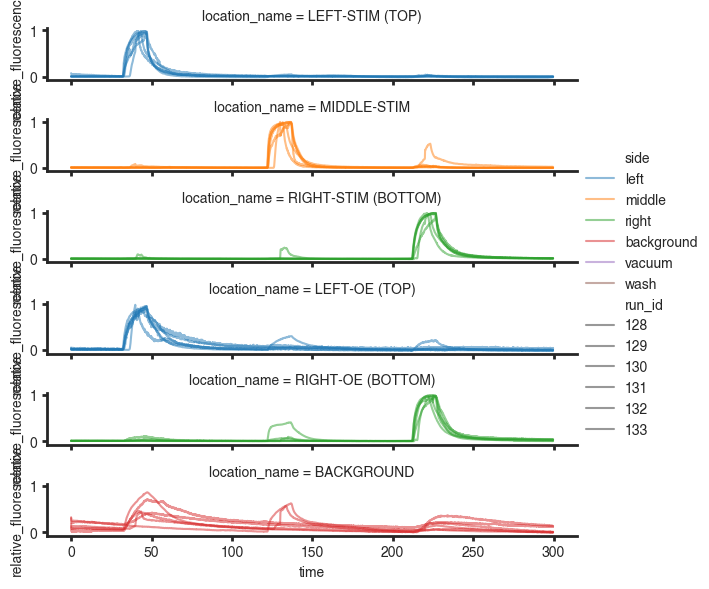

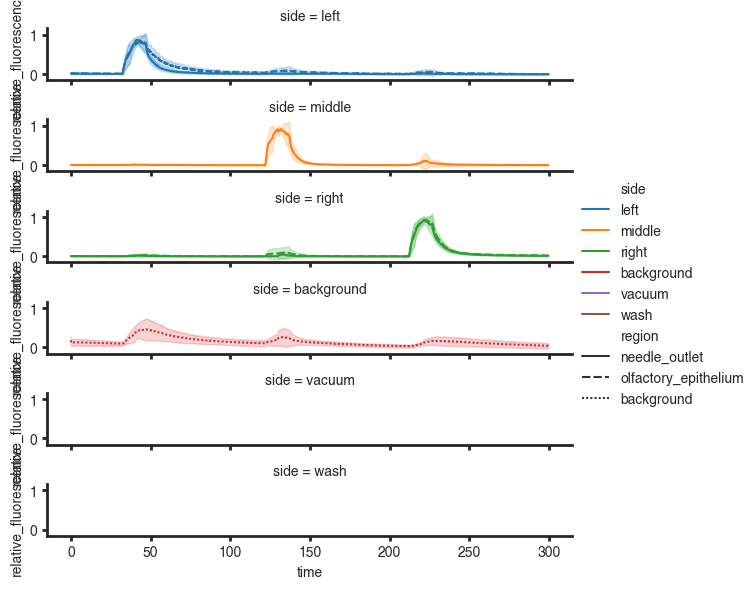

In [24]:
%matplotlib inline

# lets plot all of the timecourses 
sns.relplot(
    data=folded_timecourse_df,
    x=TIME_KEY,
    y=FLUORESCENCE_KEY,
    hue=SIDE_KEY,
    kind='line',
    row=LOCATION_KEY,
    style=RUN_ID_CN,
    dashes=False,
    facet_kws={'sharey': True, 'sharex': True},
    height=1,
    aspect=6,
    alpha=0.5)

sns.relplot(
    data=folded_timecourse_df,
    x=TIME_KEY,
    y=FLUORESCENCE_KEY,
    kind='line',
    hue=SIDE_KEY,    
    row=SIDE_KEY,
    style=REGION_KEY,
    facet_kws={'sharey': True, 'sharex': True},
    errorbar=('sd', 1),
    height=1,
    aspect=6)

## Set the Image Quantification Datafram Path

In [25]:
df_output_dir = os.path.join(
    config_list[0].output_directory, 'dataframes')
csutils.touchdir(df_output_dir)
output_path = os.path.join(df_output_dir, 'image_quantification_pd-dataframe_v2.pkl')

## Save The Image Quantification Dataframe

In [28]:
folded_timecourse_df.to_pickle(output_path)
log.info(f'Saved folded timecourse dataframe to "{output_path}".')

local-nb_cs-ii-31_dye-test-analysis (   2): INFO : Saved folded timecourse dataframe to "G:\c_swain\zf_correlative_microscopy\analyzed_and_generated_data\cs-ii-31_dye-test-outputs\dataframes\image_quantification_pd-dataframe_v2.pkl".


## Load The Image Quantification Dataframe

In [29]:
folded_timecourse_df = pd.read_pickle(output_path)

## Get utilized Run ID's

In [26]:
utilized_run_ids = set(folded_timecourse_df[RUN_ID_CN].unique())
utilized_run_ids

{128, 129, 130, 131, 132, 133}

## Get Dataset Infos for Manifold Configs, Stimulation Configs, Control Logs, and Sensor Logs 

In [27]:
manifold_config_dsi_dict = dict()
stimulation_config_dsi_dict = dict()
sensor_dsi_dict = dict()
zoss_control_dsi_dict = dict()

for run_id in utilized_run_ids:
    manifold_config_dsi_dict[run_id] = [
        dsi for dsi in all_dataset_infos
        if (dsi.run_id == run_id and dsi.type == 'odor-manifold-config')][0]
    
    stimulation_config_dsi_dict[run_id] = [
        dsi for dsi in all_dataset_infos
        if (dsi.run_id == run_id and dsi.type == 'stimulation-config')][0]
    
    sensor_dsi_dict[run_id] = [
        dsi for dsi in all_dataset_infos
        if (dsi.run_id == run_id and dsi.type == 'stimulation-sensor-log')][0]
    
    zoss_control_dsi_dict[run_id] = [
        dsi for dsi in all_dataset_infos
        if (dsi.run_id == run_id and dsi.type == 'stimulation-control-log')][0]
    
    log.info(f'Run {run_id}:\n'
             f'\t{manifold_config_dsi_dict[run_id].name}\n'
             f'\t{stimulation_config_dsi_dict[run_id].name}\n'
             f'\t{sensor_dsi_dict[run_id].name}\n'
             f'\t{zoss_control_dsi_dict[run_id].name}')

local-nb_cs-ii-31_dye-test-analysis (  23): INFO : Run 128:
	odor-manifold-config-ref-cs-ii-31_dye-test_run-128_odor-manifold-config
	stimulation-config-ref-cs-ii-31_dye-test_run-128_stim-config
	stimulation-sensor-log-ref-cs-ii-31_dye-test_run-128_stim-flow-sensor
	stimulation-control-log-ref-cs-ii-31_dye-test_run-128_stim-control
local-nb_cs-ii-31_dye-test-analysis (  23): INFO : Run 129:
	odor-manifold-config-ref-cs-ii-31_dye-test_run-129_odor-manifold-config
	stimulation-config-ref-cs-ii-31_dye-test_run-129_stim-config
	stimulation-sensor-log-ref-cs-ii-31_dye-test_run-129_stim-flow-sensor
	stimulation-control-log-ref-cs-ii-31_dye-test_run-129_stim-control
local-nb_cs-ii-31_dye-test-analysis (  23): INFO : Run 130:
	odor-manifold-config-ref-cs-ii-31_dye-test_run-130_odor-manifold-config
	stimulation-config-ref-cs-ii-31_dye-test_run-130_stim-config
	stimulation-sensor-log-ref-cs-ii-31_dye-test_run-130_stim-flow-sensor
	stimulation-control-log-ref-cs-ii-31_dye-test_run-130_stim-contro

## Parse Odor-Manifold Config

In [28]:
# read in the odor manifold config
ODOR_MANIFOLD_TABLE_KEY = 'odor-manifold-table'

# note: CN = column name
ODOR_CHANNEL_CN = 'odor-channel'
ODOR_DESCRIPTION_CN = 'odor-description'
MANIFOLD_POS_CN = 'manifold-pos'
ODOR_COLOR_CN = 'color'

# TODO - this should eventually be a object that is stored rather than a dict
manifold_config_df_dict = dict()
odor_manifold_process_dict: dict[str, dict] = dict()
for run_id, dsi in manifold_config_dsi_dict.items():
    if dsi.full_path in odor_manifold_process_dict:
        log.info('Odor manifold config already processed for "{:s}".', dsi.full_path)
        manifold_config_df_dict[run_id] = (
            odor_manifold_process_dict
            [dsi.full_path][ODOR_MANIFOLD_TABLE_KEY])
        continue
        
    odor_manifold_process_dict[dsi.full_path] = dict()
    odor_manifold_df = pd.read_csv(dsi.full_path)
    
    # cleanup column names
    odor_manifold_df.columns = odor_manifold_df.columns.str.strip()
    
    # cleanup string values
    odor_manifold_df[ODOR_DESCRIPTION_CN] = (
        odor_manifold_df[ODOR_DESCRIPTION_CN]
        .str.strip()
        .astype('category')
        .astype(ODOR_CATEGORICAL_DTYPE))
    odor_manifold_df[MANIFOLD_POS_CN] = odor_manifold_df[MANIFOLD_POS_CN].str.strip()
    
    odor_manifold_process_dict[dsi.full_path][ODOR_MANIFOLD_TABLE_KEY] = odor_manifold_df
    manifold_config_df_dict[run_id] = odor_manifold_df
    
log.info('Extracted {:d} unique odor manifold config(s).', len(odor_manifold_process_dict))
odor_manifold_df

local-nb_cs-ii-31_dye-test-analysis (  15): INFO : Odor manifold config already processed for "G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-31_zoss-system-data\odor-manifold-configs\dye_test_config.csv".
local-nb_cs-ii-31_dye-test-analysis (  15): INFO : Odor manifold config already processed for "G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-31_zoss-system-data\odor-manifold-configs\dye_test_config.csv".
local-nb_cs-ii-31_dye-test-analysis (  15): INFO : Odor manifold config already processed for "G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-31_zoss-system-data\odor-manifold-configs\dye_test_config.csv".
local-nb_cs-ii-31_dye-test-analysis (  15): INFO : Odor manifold config already processed for "G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-31_zoss-system-data\odor-manifold-configs\dye_test_config.csv".
local-nb_cs-ii-31_dye-test-analysis (  15): INFO : Odor manifold config already processed for "G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-31_zoss-s

odor-channel odor-description manifold-pos  color
0             1       fish-water        right      1
1             2       fish-water       middle      1
2             3       fish-water         left      1
3             4              dye        right      6
4             5              dye         left      6
5             6              dye       middle      6
6             7              NaN         none      9
7             8              NaN         none      9
8             9              NaN         none      9
9            10              NaN         none      9

## Determine the Valid Odor Lines
add a new column to the manifold config dataframes that indicates whether the odor line is valid

In [29]:
# determine the valid odor lines
VALID_ODOR_KEY = 'valid-odor-arr'

for run_id, df in manifold_config_df_dict.items():
    if VALID_ODOR_KEY in df.columns:
        log.info('Valid odor lines already determined for run {:d}. Skipping...', run_id)
        continue
    flag_arr = np.logical_not(df[MANIFOLD_POS_CN] == 'none')   
    df[VALID_ODOR_KEY] = flag_arr
    
df

local-nb_cs-ii-31_dye-test-analysis (   6): INFO : Valid odor lines already determined for run 129. Skipping...
local-nb_cs-ii-31_dye-test-analysis (   6): INFO : Valid odor lines already determined for run 130. Skipping...
local-nb_cs-ii-31_dye-test-analysis (   6): INFO : Valid odor lines already determined for run 131. Skipping...
local-nb_cs-ii-31_dye-test-analysis (   6): INFO : Valid odor lines already determined for run 132. Skipping...
local-nb_cs-ii-31_dye-test-analysis (   6): INFO : Valid odor lines already determined for run 133. Skipping...


odor-channel odor-description manifold-pos  color  valid-odor-arr
0             1       fish-water        right      1            True
1             2       fish-water       middle      1            True
2             3       fish-water         left      1            True
3             4              dye        right      6            True
4             5              dye         left      6            True
5             6              dye       middle      6            True
6             7              NaN         none      9           False
7             8              NaN         none      9           False
8             9              NaN         none      9           False
9            10              NaN         none      9           False

## Parse Control Log

In [30]:
RELATIVE_TIME_CN = 'rel time (s)'
STEP_NUM_CN = 'step num'

# read in the control log
zoss_control_df_dict: dict[int, pd.DataFrame] = dict()
ref_time_dict: dict[int, float] = dict()
end_time_dict: dict[int, float] = dict()
for run_id, dsi in zoss_control_dsi_dict.items():
    zoss_control_df = pandas.read_csv(dsi.full_path)
    
    # cleanup column names
    zoss_control_df.columns = zoss_control_df.columns.str.strip()
    
    ref_time = (zoss_control_df
                .loc[zoss_control_df[STEP_NUM_CN] == 0, RELATIVE_TIME_CN]
                .values[0])
    ref_time_dict[run_id] = ref_time
    end_time = (zoss_control_df
                .loc[zoss_control_df[STEP_NUM_CN] == -3, RELATIVE_TIME_CN]
                .values[0])
    end_time_dict[run_id] = end_time
    log.info(f'{dsi.run_id = }, {ref_time = }')
    zoss_control_df_dict[run_id] = zoss_control_df

zoss_control_df

local-nb_cs-ii-31_dye-test-analysis (  22): INFO : dsi.run_id = 128, ref_time = 108352.5590992
local-nb_cs-ii-31_dye-test-analysis (  22): INFO : dsi.run_id = 129, ref_time = 109196.8679955
local-nb_cs-ii-31_dye-test-analysis (  22): INFO : dsi.run_id = 130, ref_time = 110262.0741122
local-nb_cs-ii-31_dye-test-analysis (  22): INFO : dsi.run_id = 131, ref_time = 110814.4549463
local-nb_cs-ii-31_dye-test-analysis (  22): INFO : dsi.run_id = 132, ref_time = 113273.6951885
local-nb_cs-ii-31_dye-test-analysis (  22): INFO : dsi.run_id = 133, ref_time = 113880.0086678


rel time (s)  step num
0  113874.998310        -2
1  113880.000043        -1
2  113880.008668         0
3  113910.008328         1
4  113925.008379         2
5  114000.008578         3
6  114015.008625         4
7  114090.008331         5
8  114105.009336         6
9  114180.008935        -3

## Parse the Flow Sensor Data

In [32]:
# read in the sensor data
TIME_CN = 'time'
FLOW_RATE_CN_FMT = 'flow-mlpm{:02d}'
FLOW_ERR_CN_FMT = 'flow-err{:02d}'
TEMP_CN_FMT = 'temp-c{:02d}'
TEMP_ERR_CN_FMT = 'temp-err{:02d}'
HIGH_FLOW_FLAG_CN_FMT = 'high-flow{:02d}'
# AIL = air-in-line
AIL_FLAG_CN_FMT = 'air-in-line{:02d}'
FLAG_ERR_CN_FMT = 'flag-err{:02d}'

NUM_SENSORS = 12

sensor_df_dict: dict[int, pd.DataFrame] = dict()
for run_id, dsi in sensor_dsi_dict.items():
    sensor_df = pandas.read_csv(
        dsi.full_path, header=0, skiprows=1)
    
    # cleanup column names
    sensor_df.columns = sensor_df.columns.str.strip()
    
    ref_time = ref_time_dict[run_id]
    sensor_df[TIME_CN] = sensor_df[TIME_CN] - ref_time
    
    # convert flags to boolean
    for i in range(NUM_SENSORS):
        sensor_df[TIME_CN] = sensor_df[TIME_CN].astype(float)
        sensor_df[FLOW_RATE_CN_FMT.format(i)] = (
            sensor_df[FLOW_RATE_CN_FMT.format(i)].astype(float))
        sensor_df[TEMP_CN_FMT.format(i)] = (
            sensor_df[TEMP_CN_FMT.format(i)].astype(float))
        sensor_df[FLOW_ERR_CN_FMT.format(i)] = (
            sensor_df[FLOW_ERR_CN_FMT.format(i)].astype(bool))
        sensor_df[TEMP_ERR_CN_FMT.format(i)] = (
            sensor_df[TEMP_ERR_CN_FMT.format(i)].astype(bool))
        sensor_df[HIGH_FLOW_FLAG_CN_FMT.format(i)] = (
            sensor_df[HIGH_FLOW_FLAG_CN_FMT.format(i)].astype(bool))
        sensor_df[AIL_FLAG_CN_FMT.format(i)] = (
            sensor_df[AIL_FLAG_CN_FMT.format(i)].astype(bool))
        sensor_df[FLAG_ERR_CN_FMT.format(i)] = (
            sensor_df[FLAG_ERR_CN_FMT.format(i)].astype(bool))
    
    sensor_df_dict[run_id] = sensor_df
    
sensor_df.head()

time  flow-mlpm00  flow-err00  temp-c00  temp-err00  air-in-line00  \
0 -4.903470       0.0343       False    27.395       False          False   
1 -3.322034       0.0705       False    27.415       False          False   
2 -3.297159       0.0832       False    27.445       False          False   
3 -3.273049       0.0892       False    27.485       False          False   
4 -3.246431       0.0920       False    27.565       False          False   

   high-flow00  flag-err00  flow-mlpm01  flow-err01  ...  air-in-line10  \
0        False       False       0.0412       False  ...          False   
1        False       False       0.0824       False  ...          False   
2        False       False       0.0922       False  ...          False   
3        False       False       0.0960       False  ...          False   
4        False       False       0.0976       False  ...          False   

   high-flow10  flag-err10  flow-mlpm11  flow-err11  temp-c11  temp-err11  \
0        False       False        9.818       False    26.130       False   
1        False       False       11.226       False    26.280       False   
2        False       False       11.394       False    26.235       False   
3        False       False       11.410       False    26.295       False   
4        False       False       11.294       False    26.315       False   

   air-in-line11  high-flow11  flag-err11  
0          False        False       False  
1          False        False       False  
2          False        False       False  
3          False        False       False  
4          False        False       False  

[5 rows x 85 columns]

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.


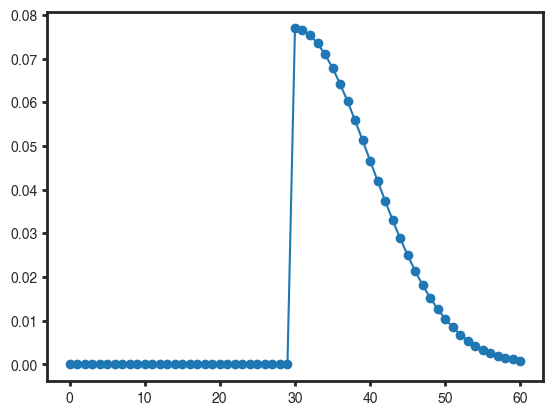

In [33]:
smooth_sigma = 10
half_width = smooth_sigma * 3
convolve_kernel = np.arange(-half_width, half_width + 1)
convolve_kernel = np.exp(-convolve_kernel ** 2 / (2 * smooth_sigma ** 2))
convolve_kernel[:half_width] = 0
convolve_kernel = convolve_kernel / np.sum(convolve_kernel)

%matplotlib inline
plt.figure()
plt.plot(convolve_kernel, marker='o')
plt.show()

In [34]:
def filter_and_resample(
        series: pd.Series,
        original_time_arr: np.ndarray | pd.Series,
        new_time_arr: np.ndarray | pd.Series,
        smooth_sigma_ms: [float | int | None] = 66,
        three_sample_median: bool = True) -> pd.Series:
        """Filter and resample a series to a new time array."""
        
        series = series.copy()
        
        if three_sample_median:
            series = (series
                      .rolling(3, center=False, min_periods=1)
                      .median())
            
        series_rs = np.interp(new_time_arr, original_time_arr, series)
        series_rs = pd.Series(series_rs)
        
        new_time_arr = pd.Series(new_time_arr)
        if smooth_sigma_ms is not None:
            smooth_sigma_samples = (smooth_sigma_ms / 1e3) / new_time_arr.diff().median()
            half_width = int(smooth_sigma_samples * 2.5)
            convolve_kernel = np.arange(-half_width, half_width + 1)
            convolve_kernel = np.exp(-convolve_kernel ** 2 / (2 * smooth_sigma_samples ** 2))            
            convolve_kernel[:half_width] = 0
            convolve_kernel = convolve_kernel / np.sum(convolve_kernel)
            # log.debug(f'{smooth_sigma_samples = }')
            # series_rs = scipy.ndimage.gaussian_filter1d(
            #     series_rs, smooth_sigma_samples, mode='nearest')
            series_rs = scipy.ndimage.convolve1d(
                series_rs, convolve_kernel, mode='nearest')
        return series_rs
        
def resample_boolean_arr(
        series: pd.Series,
        original_time_arr: np.ndarray | pd.Series,
        new_time_arr: np.ndarray | pd.Series) -> pd.Series:
        """Filter and resample a boolean series to a new time array.""" 
        
        series = series.copy()
        series.index = original_time_arr
        series_rs = series.reindex(new_time_arr, method='nearest')        
        return series_rs.reset_index(drop=True)

In [35]:
ref_sensor_dt = None
start_time = None
stop_time = None

for run_id, sensor_df in sensor_df_dict.items():
    time_arr = sensor_df[TIME_CN]
    time_delta_arr = time_arr.diff()
    time_delta_lower_qtile = time_delta_arr.quantile(0.10)
    if ref_sensor_dt is None or time_delta_lower_qtile < ref_sensor_dt:
        ref_sensor_dt = time_delta_lower_qtile
        
    this_run_start_time = time_arr.iloc[0]
    this_run_stop_time = time_arr.iloc[-1]
    if start_time is None or this_run_start_time > start_time:
        start_time = np.ceil(this_run_start_time)
        
    if stop_time is None or this_run_stop_time < stop_time:
        stop_time = np.floor(this_run_stop_time)

log.info(f'{1 / ref_sensor_dt = } Hz')
log.info(f'{start_time = }')
log.info(f'{stop_time = }')

NYQUIST_FACTOR = 2.3
desired_dt = np.round(ref_sensor_dt / NYQUIST_FACTOR, 3) 
log.info(f'{1 / desired_dt = } Hz')
new_time_arr = np.arange(start_time, stop_time, desired_dt)
new_time_arr = pd.Series(new_time_arr)

log.info(f'{new_time_arr.shape = }')

local-nb_cs-ii-31_dye-test-analysis (  20): INFO : 1 / ref_sensor_dt = 42.91274552329949 Hz
local-nb_cs-ii-31_dye-test-analysis (  21): INFO : start_time = -4.0
local-nb_cs-ii-31_dye-test-analysis (  22): INFO : stop_time = 303.0
local-nb_cs-ii-31_dye-test-analysis (  26): INFO : 1 / desired_dt = 100.0 Hz
local-nb_cs-ii-31_dye-test-analysis (  30): INFO : new_time_arr.shape = (30700,)


In [37]:
flow_df_dict: dict[int, pd.DataFrame] = dict()

PRETTY_TIME_CN = 'Time (s)'
ODOR_PRETTY_NAME_FMT = 'Odor {:d} Line, {}'
WASH_LINE_PRETTY_NAME = 'Wash Line, Fish Water'
VACUUM_LINE_PRETTY_NAME = 'Vacuum Line, Fish Water'

SENSOR_ID_CN = 'sensor-id'
ODORANT_DESC_CN = 'odorant'
FLOW_RATE_CN = 'flow-rate-mlpm'
RELATIVE_FLOW_RATE_CN = 'relative-flow-rate'
TEMP_CN = 'temp-c'
AIL_FLAG_CN = 'air-in-line'
HIGH_FLOW_FLAG_CN = 'high-flow'
LINE_TYPE_CN = 'line-type'

for run_id, sensor_df in sensor_df_dict.items():
    dsi = sensor_dsi_dict[run_id]
    manifold_df = manifold_config_df_dict[run_id]
    
    sensor_flow_subdfs: list[pd.DataFrame] = []    
    for i in range(NUM_SENSORS):
        odor_name: str
        if i >= 10:
            odor_desc = FISH_WATER_NAME
            manifold_pos = 'wash' if i == 10 else 'vacuum'
            line_type = WASH_LINE_TYPE
            norm_qtile = 0.5
        elif not manifold_df.loc[i, VALID_ODOR_KEY]:
            continue
        else:
            line_type = ODOR_LINE_TYPE
            odor_desc = manifold_df.loc[i, ODOR_DESCRIPTION_CN]
            manifold_pos = manifold_df.loc[i, MANIFOLD_POS_CN]
            norm_qtile = 0.999
                     
        raw_time_arr = sensor_df[TIME_CN].copy()
                     
        flow_arr = sensor_df[FLOW_RATE_CN_FMT.format(i)].copy()        
        flow_issue_arr = (
            sensor_df[FLAG_ERR_CN_FMT.format(i)]
            | ((sensor_df[HIGH_FLOW_FLAG_CN_FMT.format(i)]
                | sensor_df[AIL_FLAG_CN_FMT.format(i)])
               & np.logical_not(sensor_df[FLOW_ERR_CN_FMT.format(i)])))
        flow_arr[flow_issue_arr] = pd.NA
        flow_arr_rs = filter_and_resample(flow_arr, raw_time_arr, new_time_arr)
        
        rel_flow_arr = (
            flow_arr_rs 
            / np.quantile(flow_arr_rs[~np.isnan(flow_arr_rs)], 
                          norm_qtile))
        
        temp_arr = sensor_df[TEMP_CN_FMT.format(i)].copy()
        temp_issue_arr = sensor_df[TEMP_ERR_CN_FMT.format(i)]
        temp_arr[temp_issue_arr] = pd.NA
        temp_arr_rs = filter_and_resample(temp_arr, raw_time_arr, new_time_arr)
        
        ail_arr = sensor_df[AIL_FLAG_CN_FMT.format(i)].copy()
        hf_arr = sensor_df[HIGH_FLOW_FLAG_CN_FMT.format(i)].copy()
        flag_issue_arr = sensor_df[FLAG_ERR_CN_FMT.format(i)]
        ail_arr[flag_issue_arr] = pd.NA
        hf_arr[flag_issue_arr] = pd.NA
        ail_arr_rs = resample_boolean_arr(ail_arr, raw_time_arr, new_time_arr)
        hf_arr_rs = resample_boolean_arr(hf_arr, raw_time_arr, new_time_arr)
        
        sensor_flow_df = pd.DataFrame({
            TIME_CN: new_time_arr.copy(),
            SENSOR_ID_CN: i,
            FLOW_RATE_CN: flow_arr_rs,
            RELATIVE_FLOW_RATE_CN: rel_flow_arr,
            TEMP_CN: temp_arr_rs,
            AIL_FLAG_CN: ail_arr_rs,
            HIGH_FLOW_FLAG_CN: hf_arr_rs,
            ODORANT_DESC_CN: odor_desc,
            MANIFOLD_POS_CN: manifold_pos,
            LINE_TYPE_CN: line_type,
            RUN_ID_CN: run_id,
            EXPERIMENT_ID_CN: dsi.data['experiment-id']})        
        
        sensor_flow_subdfs.append(sensor_flow_df)
        
    all_sensor_flow_df = pd.concat(sensor_flow_subdfs, ignore_index=True)
    all_sensor_flow_df[SENSOR_ID_CN] = (
        all_sensor_flow_df[SENSOR_ID_CN].astype('category'))
    all_sensor_flow_df[ODORANT_DESC_CN] = (
        all_sensor_flow_df[ODORANT_DESC_CN].astype(ODOR_CATEGORICAL_DTYPE))
    all_sensor_flow_df[MANIFOLD_POS_CN] = (
        all_sensor_flow_df[MANIFOLD_POS_CN].astype(SIDE_CATEGORICAL_DTYPE))
    all_sensor_flow_df[LINE_TYPE_CN] = (
        all_sensor_flow_df[LINE_TYPE_CN].astype(LINE_TYPE_CATEGORICAL_DTYPE))
    all_sensor_flow_df[RUN_ID_CN] = (
        all_sensor_flow_df[RUN_ID_CN].astype('category'))
    all_sensor_flow_df[EXPERIMENT_ID_CN] = (
        all_sensor_flow_df[EXPERIMENT_ID_CN].astype('category'))
    flow_df_dict[run_id] = all_sensor_flow_df 
    
multirun_flow_df = pd.concat(flow_df_dict.values(), ignore_index=True)

multirun_flow_df.head()

time sensor-id  flow-rate-mlpm  relative-flow-rate     temp-c  air-in-line  \
0 -4.00         0        0.018547            0.352984  27.870397        False   
1 -3.99         0        0.018552            0.353064  27.870417        False   
2 -3.98         0        0.018560            0.353224  27.870456        False   
3 -3.97         0        0.018572            0.353461  27.870516        False   
4 -3.96         0        0.018589            0.353771  27.870593        False   

   high-flow     odorant manifold-pos line-type  run_id experiment_id  
0      False  fish-water        right      odor     128      cs-ii-31  
1      False  fish-water        right      odor     128      cs-ii-31  
2      False  fish-water        right      odor     128      cs-ii-31  
3      False  fish-water        right      odor     128      cs-ii-31  
4      False  fish-water        right      odor     128      cs-ii-31

## Preview the Flow Sensor Data

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.


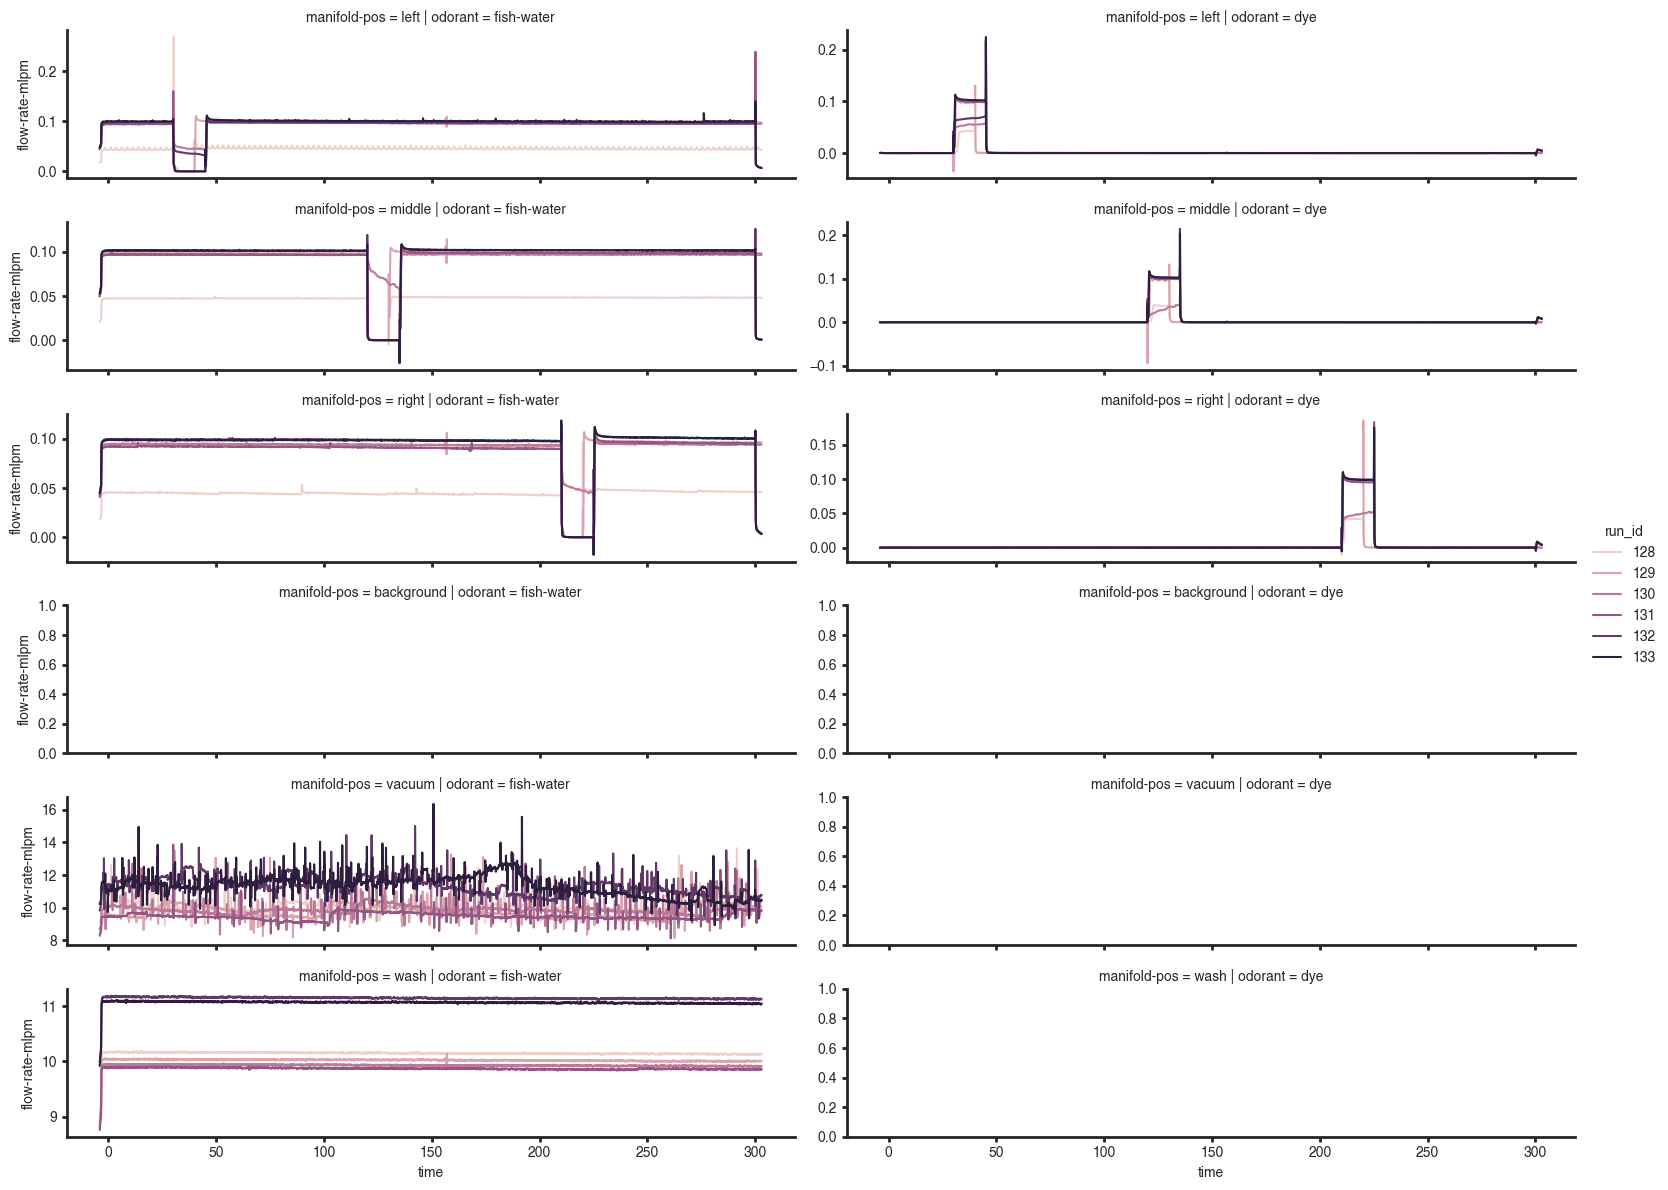

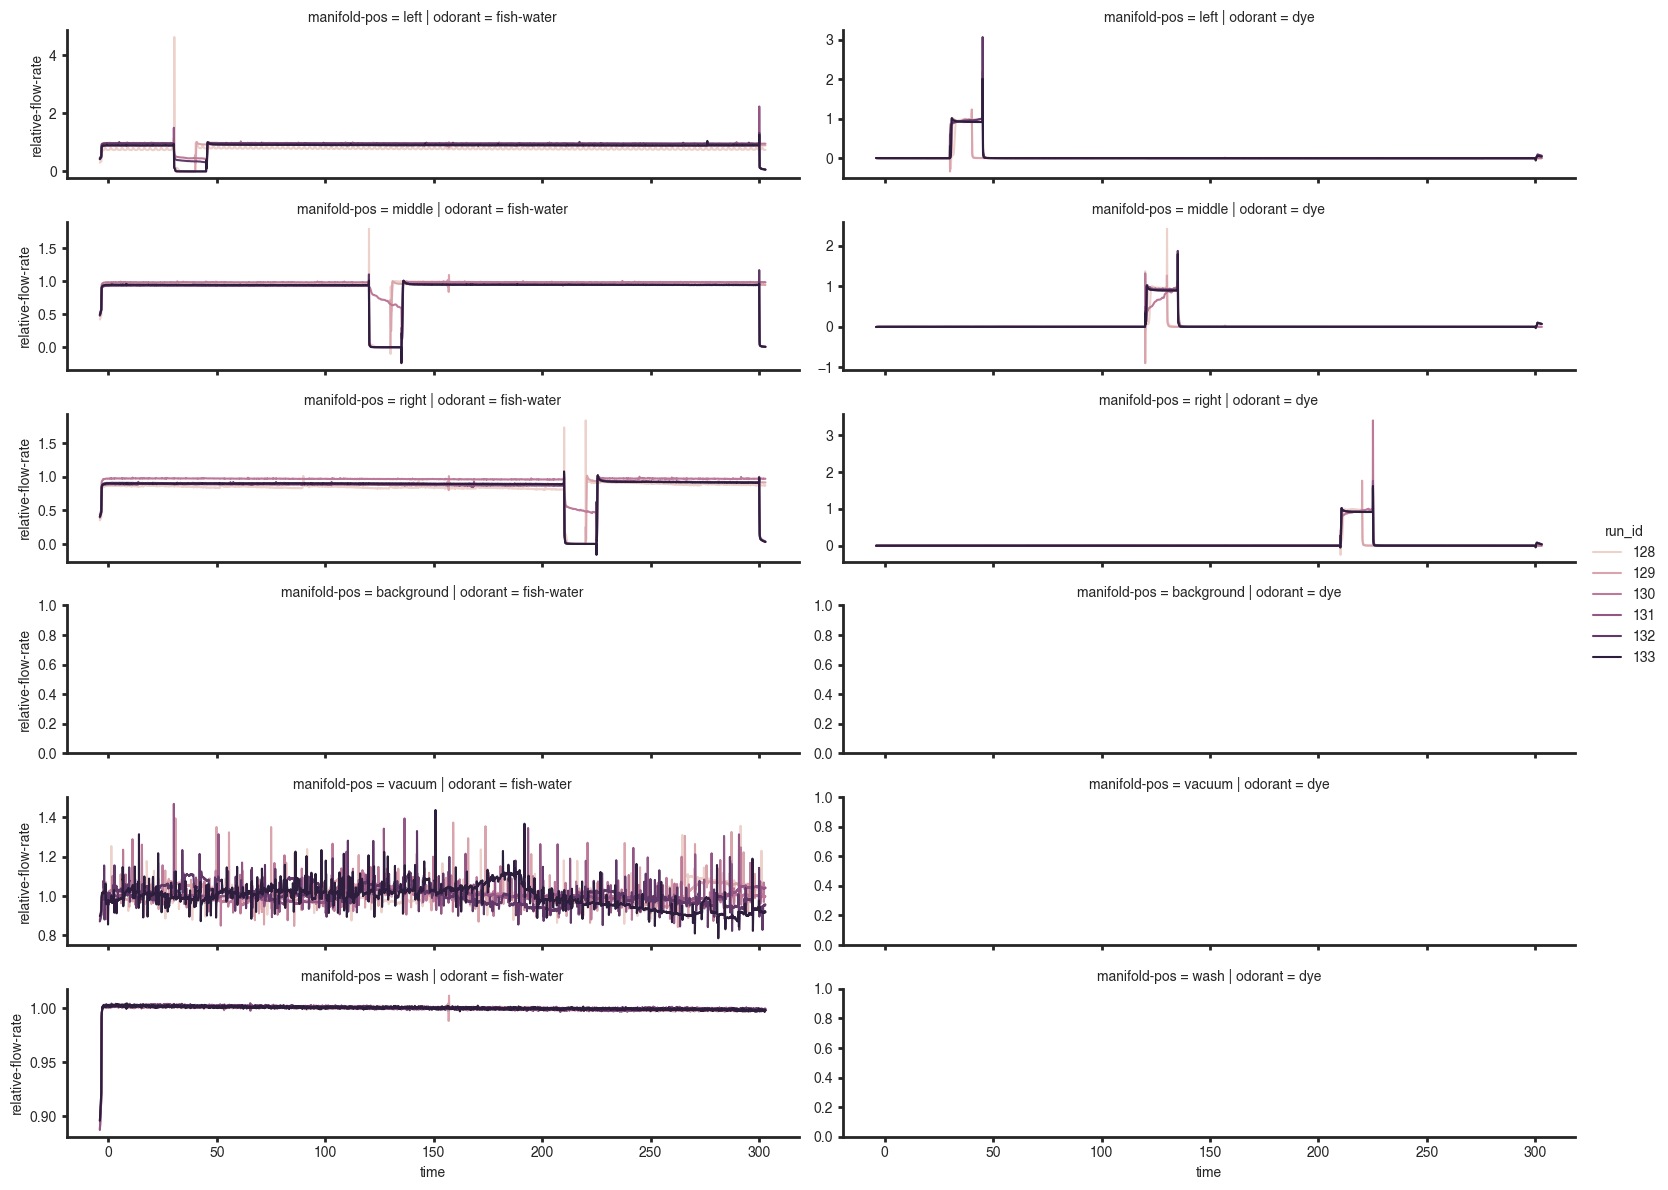

In [38]:
%matplotlib inline

relplot_kwargs = dict(
    data=multirun_flow_df,
    x=TIME_CN,
    kind='line',
    hue=RUN_ID_CN,
    row=MANIFOLD_POS_CN,
    col=ODORANT_DESC_CN,
    facet_kws={'sharey': False, 'sharex': True},
    errorbar=('sd', 1),
    height=2,
    aspect=4,
)

sns.relplot(
    y=FLOW_RATE_CN,
    **relplot_kwargs)

sns.relplot(
    y=RELATIVE_FLOW_RATE_CN,
    **relplot_kwargs)

## Parse the Simulation Configs

In [39]:
# mapping dict for stim config names to stim-type names
category_remap_dict = {
    'cs-ii-31': {
        'prime': 'equilibration',
        'left': 'pulse',
        'wash': 'break',
        'middle': 'pulse',
        'right': 'pulse',
        'final-flush': 'break',
    }
}

stim_config_df_dict: dict[int, pd.DataFrame] = dict()

manifold_positions = [
    'left', 'middle', 'right'
]
MANIFOLD_NAME_CN_FMT = '{:s}-name'
MANIFOLD_INDEX_CN_FMT = '{:s}-index'
DURATION_CN = 'duration_s'
STIM_DESCRIPTION_CN = 'description'
STIM_TYPE_CN = 'stim-type'
FLAG_CN = 'flag'
ACTUAL_START_TIME_CN = 'actual-rel-start-time_s'
RUN_ID_CN = 'run-id'
EXPERIMENT_ID_CN = 'experiment-id'
STIM_STEP_NUMBER_CN = 'stim-step-index'
LINES_CHANGED_CN = 'lines-changed'
TURN_ON_LINES_CN = 'turned-on-lines'
TURN_OFF_LINES_CN = 'turned-off-lines'

for run_id, dsi in stimulation_config_dsi_dict.items():        
    csv_path = dsi.full_path
    stim_config_df = pd.read_csv(csv_path)
    
    stim_config_df.columns = stim_config_df.columns.str.strip()
    for manifold_pos in manifold_positions:  
        odor_number_to_name_dict = (
            manifold_config_df_dict
            [run_id]              
            [ODOR_DESCRIPTION_CN]
            .to_dict())
        odor_number_to_name_dict = {
            k: v for k, v in odor_number_to_name_dict.items() if isinstance(v, str)}
        
        manifold_index_cn = MANIFOLD_INDEX_CN_FMT.format(manifold_pos)
        stim_config_df[manifold_index_cn] = stim_config_df[manifold_pos].astype(int) - 1
        manifold_name_cn = MANIFOLD_NAME_CN_FMT.format(manifold_pos)
        stim_config_df[manifold_name_cn] = (
            stim_config_df[manifold_index_cn]
            .astype('category')
            .cat.rename_categories(odor_number_to_name_dict)
            .astype(ODOR_CATEGORICAL_DTYPE))
        stim_config_df.drop(columns=manifold_pos, inplace=True)
    stim_config_df[DURATION_CN] = stim_config_df[DURATION_CN].astype(float)
    stim_config_df[FLAG_CN] = stim_config_df[FLAG_CN].astype(bool)
    stim_config_df[STIM_DESCRIPTION_CN] = stim_config_df[STIM_DESCRIPTION_CN].str.strip()
    stim_config_df[STIM_TYPE_CN] = stim_config_df.loc[:, STIM_DESCRIPTION_CN].copy()
     
    lines_changed_list = []   
    lines_on_list = []
    lines_off_list = []
    for i, (_, stim_row) in enumerate(stim_config_df.iterrows()):        
        lines_changed_sublist = []
        lines_on_sublist = []
        lines_off_sublist = []
        if not (i == 0):                    
            for manifold_pos in manifold_positions:
                manifold_index_cn = MANIFOLD_INDEX_CN_FMT.format(manifold_pos)
                prior_mi = prior_row[manifold_index_cn]  # mi = manifold index
                current_mi = stim_row[manifold_index_cn]
                if prior_mi != current_mi:
                    lines_changed_sublist.extend([prior_mi, current_mi])    
                    lines_on_sublist.append(current_mi)
                    lines_off_sublist.append(prior_mi)
                    
        lines_changed_sublist.sort()
        lines_on_sublist.sort()
        lines_off_sublist.sort()
        lines_changed_list.append(lines_changed_sublist)
        lines_on_list.append(lines_on_sublist)
        lines_off_list.append(lines_off_sublist)
        prior_row = stim_row
    stim_config_df[LINES_CHANGED_CN] = lines_changed_list
    stim_config_df[TURN_ON_LINES_CN] = lines_on_list
    stim_config_df[TURN_OFF_LINES_CN] = lines_off_list
        
    remap_dict = category_remap_dict[dsi.data['experiment-id']]    
    for k, v in remap_dict.items():
        # lookup mask 
        mask = stim_config_df[STIM_TYPE_CN] == k
        stim_config_df.loc[mask, STIM_TYPE_CN] = v
    
    stim_config_df.loc[0, STIM_TYPE_CN] = 'equilibration'
    stim_config_df[STIM_TYPE_CN] = (
        stim_config_df[STIM_TYPE_CN]
        .astype(STIM_TYPE_CATEGORICAL_DTYPE))
    
    stim_config_df[ACTUAL_START_TIME_CN] = (
        zoss_control_df_dict[run_id]
        .set_index(STEP_NUM_CN)
        .loc[:, RELATIVE_TIME_CN]
        .copy()
        - ref_time_dict[run_id])
    
    stim_config_df[EXPERIMENT_ID_CN] = dsi.data['experiment-id']
    stim_config_df[RUN_ID_CN] = dsi.run_id
    stim_config_df[RUN_ID_CN] = stim_config_df[RUN_ID_CN].astype('category')
    stim_config_df[STIM_STEP_NUMBER_CN] = stim_config_df.index
    
    stim_config_df_dict[run_id] = stim_config_df
    
stim_config_df

description  duration_s   flag  left-index   left-name  middle-index  \
0        prime        30.0  False           2  fish-water             1   
1         left        15.0  False           4         dye             1   
2         wash        75.0  False           2  fish-water             1   
3       middle        15.0  False           2  fish-water             5   
4         wash        75.0  False           2  fish-water             1   
5        right        15.0  False           2  fish-water             1   
6  final-flush        75.0  False           2  fish-water             1   

  middle-name  right-index  right-name      stim-type lines-changed  \
0  fish-water            0  fish-water  equilibration            []   
1  fish-water            0  fish-water          pulse        [2, 4]   
2  fish-water            0  fish-water          break        [2, 4]   
3         dye            0  fish-water          pulse        [1, 5]   
4  fish-water            0  fish-water          break        [1, 5]   
5  fish-water            3         dye          pulse        [0, 3]   
6  fish-water            0  fish-water          break        [0, 3]   

  turned-on-lines turned-off-lines  actual-rel-start-time_s experiment-id  \
0              []               []                 0.000000      cs-ii-31   
1             [4]              [2]                29.999661      cs-ii-31   
2             [2]              [4]                44.999712      cs-ii-31   
3             [5]              [1]               119.999911      cs-ii-31   
4             [1]              [5]               134.999957      cs-ii-31   
5             [3]              [0]               209.999663      cs-ii-31   
6             [0]              [3]               225.000668      cs-ii-31   

  run-id  stim-step-index  
0    133                0  
1    133                1  
2    133                2  
3    133                3  
4    133                4  
5    133                5  
6    133                6

In [40]:
multirun_stim_config_df = pd.concat(stim_config_df_dict.values(), ignore_index=True)

log.info(f'{multirun_stim_config_df.shape = }')
multirun_stim_config_df.head()

local-nb_cs-ii-31_dye-test-analysis (   3): INFO : multirun_stim_config_df.shape = (42, 17)


description  duration_s   flag  left-index   left-name  middle-index  \
0       prime        30.0  False           2  fish-water             1   
1        left        10.0  False           4         dye             1   
2        wash        80.0  False           2  fish-water             1   
3      middle        10.0  False           2  fish-water             5   
4        wash        80.0  False           2  fish-water             1   

  middle-name  right-index  right-name      stim-type lines-changed  \
0  fish-water            0  fish-water  equilibration            []   
1  fish-water            0  fish-water          pulse        [2, 4]   
2  fish-water            0  fish-water          break        [2, 4]   
3         dye            0  fish-water          pulse        [1, 5]   
4  fish-water            0  fish-water          break        [1, 5]   

  turned-on-lines turned-off-lines  actual-rel-start-time_s experiment-id  \
0              []               []                 0.000000      cs-ii-31   
1             [4]              [2]                29.999758      cs-ii-31   
2             [2]              [4]                39.999725      cs-ii-31   
3             [5]              [1]               120.001124      cs-ii-31   
4             [1]              [5]               130.001392      cs-ii-31   

   run-id  stim-step-index  
0     128                0  
1     128                1  
2     128                2  
3     128                3  
4     128                4

## Expand Stim Config into Stim Control Timecourses

In [42]:
STIM_STATUS_CN = 'stim-status'
LINE_INDEX_CN = 'line-index'

stim_control_dfs = []
for run_id, stim_config_df in stim_config_df_dict.items():
    dsi = stimulation_config_dsi_dict[run_id]
    num_rows = stim_config_df.shape[0]
    manifold_df = manifold_config_df_dict[run_id]
    
    odor_control_timecours_dict = dict()
    time_arr = []
    for i, stim_row in stim_config_df.iterrows():
        begin_time = stim_row[ACTUAL_START_TIME_CN]
        if i == num_rows - 1:
            end_time = begin_time + stim_row[DURATION_CN]
        else:
            end_time = stim_config_df.loc[i + 1, ACTUAL_START_TIME_CN]
            end_time -= 1e-6
        
        time_arr += [begin_time, end_time]         
            
        if end_time is None:
            append_on_val = [1, ]
            append_off_val = [0, ]
        else:
            append_on_val = [1, 1]
            append_off_val = [0, 0]
            
        for j, manifold_row in manifold_df.iterrows():
            if not manifold_row[VALID_ODOR_KEY]:
                continue
            
            try:
                _ = odor_control_timecours_dict[j]
            except KeyError:
                odor_control_timecours_dict[j] = dict()            
            
            # FIXME - this can be done in a different way now that there is an 
            #  index col       
            manifold_name_cn = MANIFOLD_NAME_CN_FMT.format(manifold_row[MANIFOLD_POS_CN])
            if (stim_row[manifold_name_cn] 
                    == manifold_row[ODOR_DESCRIPTION_CN]):
                append_val = append_on_val
            else:
                append_val = append_off_val
            try:
                odor_control_timecours_dict[j][STIM_STATUS_CN].extend(append_val)
            except KeyError:
                odor_control_timecours_dict[j][STIM_STATUS_CN] = append_val.copy()
                
    for j, manifold_row in manifold_df.iterrows():
        if not manifold_row[VALID_ODOR_KEY]:
            continue
        odor_control_timecours_dict[j][TIME_CN] = new_time_arr
        odor_control_timecours_dict[j][STIM_STATUS_CN] = np.interp(
            new_time_arr, time_arr, odor_control_timecours_dict[j][STIM_STATUS_CN])
        odor_control_timecours_dict[j][ODOR_CHANNEL_CN] = manifold_row[ODOR_CHANNEL_CN]
        odor_control_timecours_dict[j][LINE_INDEX_CN] = manifold_row[ODOR_CHANNEL_CN] - 1
        odor_control_timecours_dict[j][ODORANT_DESC_CN] = manifold_row[ODOR_DESCRIPTION_CN]
        odor_control_timecours_dict[j][MANIFOLD_POS_CN] = manifold_row[MANIFOLD_POS_CN]
        odor_control_timecours_dict[j][RUN_ID_CN] = run_id
        odor_control_timecours_dict[j][EXPERIMENT_ID_CN] = dsi.data['experiment-id']
        odor_control_timecours_dict[j][LINE_TYPE_CN] = ODOR_LINE_TYPE
                
    stim_control_dfs.append(
        pd.concat(
            [pd.DataFrame(x) for x in odor_control_timecours_dict.values()],
            ignore_index=True))
   
multirun_stim_control_df = pd.concat(stim_control_dfs, ignore_index=True)

log.info(f'{multirun_stim_control_df.shape = }')
multirun_stim_control_df.head()

local-nb_cs-ii-31_dye-test-analysis (  72): INFO : multirun_stim_control_df.shape = (1105200, 9)


stim-status  time  odor-channel  line-index     odorant manifold-pos  \
0          1.0 -4.00             1           0  fish-water        right   
1          1.0 -3.99             1           0  fish-water        right   
2          1.0 -3.98             1           0  fish-water        right   
3          1.0 -3.97             1           0  fish-water        right   
4          1.0 -3.96             1           0  fish-water        right   

   run-id experiment-id line-type  
0     128      cs-ii-31      odor  
1     128      cs-ii-31      odor  
2     128      cs-ii-31      odor  
3     128      cs-ii-31      odor  
4     128      cs-ii-31      odor

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.


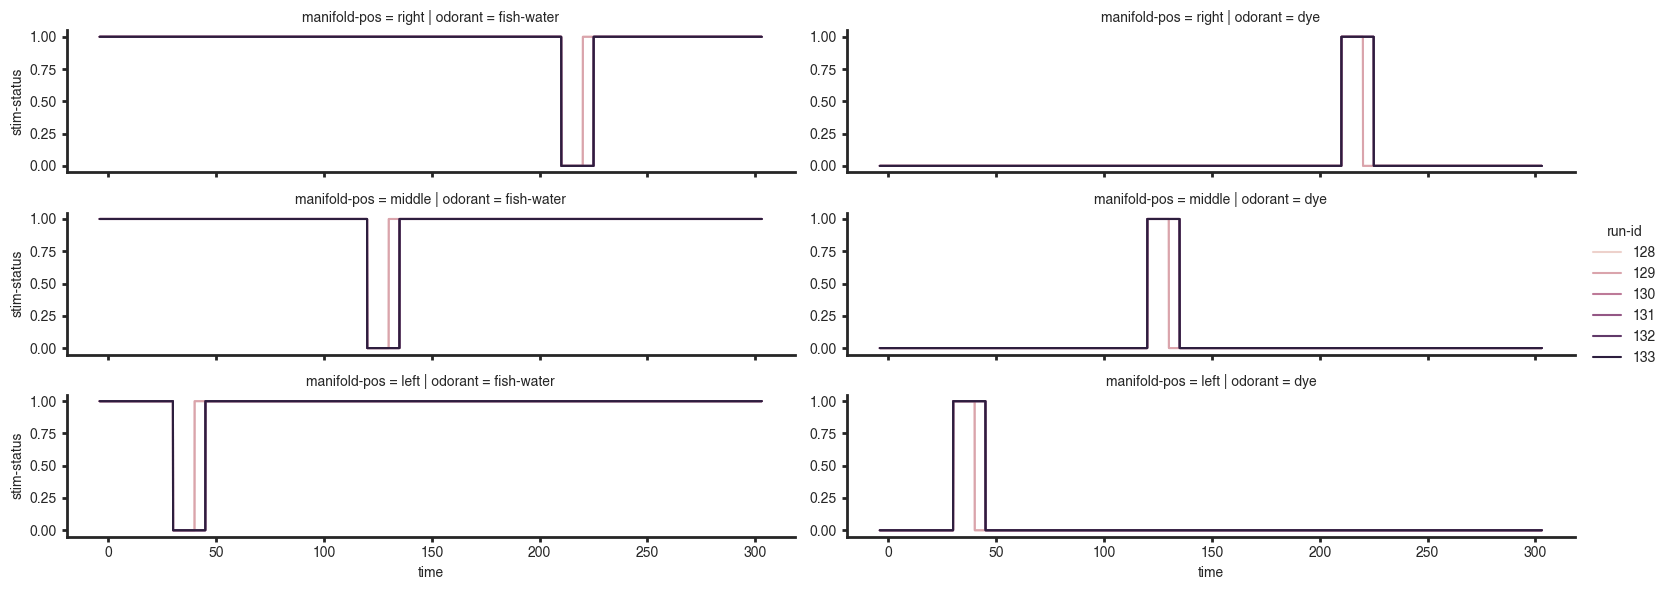

In [43]:
%matplotlib inline

sns.relplot(
    data=multirun_stim_control_df,
    x=TIME_CN,
    y=STIM_STATUS_CN,
    kind='line',
    hue=RUN_ID_CN,
    row=MANIFOLD_POS_CN,
    col=ODORANT_DESC_CN,
    facet_kws={'sharey': False, 'sharex': True},
    height=2,
    aspect=4)

In [45]:
multirun_stim_control_df.to_pickle(os.path.join(df_output_dir, 'stim_control_pd-dataframe_v2.pkl'))
multirun_flow_df.to_pickle(os.path.join(df_output_dir, 'flow_sensor_pd-dataframe_v2.pkl'))

## Resample Imaging Data to Flow Sensor Timebase

In [44]:
multirun_imaging_df = folded_timecourse_df.copy()

all_columns = multirun_imaging_df.columns

multiindex_columns = [
    c for c in all_columns
    if c not in [TIME_CN, FLUORESCENCE_KEY]]

pivot = multirun_imaging_df.pivot(
    columns=multiindex_columns,
    index=TIME_CN,
    values=FLUORESCENCE_KEY)

log.info(f'{pivot.shape =}')

original_time_arr = pivot.index.to_numpy()

resampled_pivot = pd.DataFrame(
    columns=pivot.columns,
    index=pd.Index(new_time_arr, name=TIME_CN))

# TODO - see if there is a way to interp the whole dataframe at once.
#   The scipy function scipy.interpolate.interp1d is beginning to be 
#   deprecated so I'm doing it this way, but there should be an 
#   alternative somewhere.
for col in pivot.columns: 
    resampled_pivot[col] = np.interp(
        new_time_arr, original_time_arr, pivot[col])
    
log.info(f'{resampled_pivot.shape = }')
resampled_pivot.head()

local-nb_cs-ii-31_dye-test-analysis (  14): INFO : pivot.shape =(10397, 36)
local-nb_cs-ii-31_dye-test-analysis (  30): INFO : resampled_pivot.shape = (30700, 36)


experiment_id        cs-ii-31                                                  \
run_id                    128             129             130             131   
location_name LEFT-STIM (TOP) LEFT-STIM (TOP) LEFT-STIM (TOP) LEFT-STIM (TOP)   
side                     left            left            left            left   
region          needle_outlet   needle_outlet   needle_outlet   needle_outlet   
time                                                                            
-4.00                0.001326        0.001149        0.007271        0.000548   
-3.99                0.001326        0.001149        0.007271        0.000548   
-3.98                0.001326        0.001149        0.007271        0.000548   
-3.97                0.001326        0.001149        0.007271        0.000548   
-3.96                0.001326        0.001149        0.007271        0.000548   

experiment_id                                                              \
run_id                    132             133           128           129   
location_name LEFT-STIM (TOP) LEFT-STIM (TOP)   MIDDLE-STIM   MIDDLE-STIM   
side                     left            left        middle        middle   
region          needle_outlet   needle_outlet needle_outlet needle_outlet   
time                                                                        
-4.00                0.073313        0.010656      0.008516      0.000266   
-3.99                0.073313        0.010656      0.008516      0.000266   
-3.98                0.073313        0.010656      0.008516      0.000266   
-3.97                0.073313        0.010656      0.008516      0.000266   
-3.96                0.073313        0.010656      0.008516      0.000266   

experiment_id                              ...                       \
run_id                  130           131  ...                  130   
location_name   MIDDLE-STIM   MIDDLE-STIM  ...    RIGHT-OE (BOTTOM)   
side                 middle        middle  ...                right   
region        needle_outlet needle_outlet  ... olfactory_epithelium   
time                                       ...                        
-4.00              0.004299      0.000463  ...             0.003744   
-3.99              0.004299      0.000463  ...             0.003744   
-3.98              0.004299      0.000463  ...             0.003744   
-3.97              0.004299      0.000463  ...             0.003744   
-3.96              0.004299      0.000463  ...             0.003744   

experiment_id                                                                 \
run_id                         131                  132                  133   
location_name    RIGHT-OE (BOTTOM)    RIGHT-OE (BOTTOM)    RIGHT-OE (BOTTOM)   
side                         right                right                right   
region        olfactory_epithelium olfactory_epithelium olfactory_epithelium   
time                                                                           
-4.00                      0.00165             0.005429             0.003184   
-3.99                      0.00165             0.005429             0.003184   
-3.98                      0.00165             0.005429             0.003184   
-3.97                      0.00165             0.005429             0.003184   
-3.96                      0.00165             0.005429             0.003184   

experiment_id                                                         \
run_id               128        129        130        131        132   
location_name BACKGROUND BACKGROUND BACKGROUND BACKGROUND BACKGROUND   
side          background background background background background   
region        background background background background background   
time                                                                   
-4.00           0.186989   0.130218   0.301227   0.044802    0.32208   
-3.99           0.186989   0.130218   0.301227   0.044802    0.32208   
-3.98           0.186

In [45]:
multirun_imaging_df = (
    resampled_pivot
    .melt(value_name=FLUORESCENCE_KEY, ignore_index=False)
    .reset_index())

multirun_imaging_df[ODORANT_DESC_CN] = DYE_NAME

log.info(f'{multirun_imaging_df.shape = }')
multirun_imaging_df.head()

local-nb_cs-ii-31_dye-test-analysis (   8): INFO : multirun_imaging_df.shape = (1105200, 8)


time experiment_id  run_id    location_name  side         region  \
0 -4.00      cs-ii-31     128  LEFT-STIM (TOP)  left  needle_outlet   
1 -3.99      cs-ii-31     128  LEFT-STIM (TOP)  left  needle_outlet   
2 -3.98      cs-ii-31     128  LEFT-STIM (TOP)  left  needle_outlet   
3 -3.97      cs-ii-31     128  LEFT-STIM (TOP)  left  needle_outlet   
4 -3.96      cs-ii-31     128  LEFT-STIM (TOP)  left  needle_outlet   

   relative_fluorescence odorant  
0               0.001326     dye  
1               0.001326     dye  
2               0.001326     dye  
3               0.001326     dye  
4               0.001326     dye

## Preview all of the Dataframes

In [46]:
MASTER_TIME_ARR = new_time_arr
MASTER_DT = desired_dt

In [47]:
log.info(f'{multirun_stim_config_df.shape = }')
multirun_stim_config_df.head(1)

local-nb_cs-ii-31_dye-test-analysis (   1): INFO : multirun_stim_config_df.shape = (42, 17)


description  duration_s   flag  left-index   left-name  middle-index  \
0       prime        30.0  False           2  fish-water             1   

  middle-name  right-index  right-name      stim-type lines-changed  \
0  fish-water            0  fish-water  equilibration            []   

  turned-on-lines turned-off-lines  actual-rel-start-time_s experiment-id  \
0              []               []                      0.0      cs-ii-31   

   run-id  stim-step-index  
0     128                0

In [48]:
(multirun_flow_df
 .rename(
    columns={
        'run_id': RUN_ID_CN,
        'experiment_id': EXPERIMENT_ID_CN}, 
    inplace=True))
    
log.info(f'{multirun_flow_df.shape = }')
multirun_flow_df.head(1)

local-nb_cs-ii-31_dye-test-analysis (   8): INFO : multirun_flow_df.shape = (1473600, 12)


time sensor-id  flow-rate-mlpm  relative-flow-rate     temp-c  air-in-line  \
0  -4.0         0        0.018547            0.352984  27.870397        False   

   high-flow     odorant manifold-pos line-type  run-id experiment-id  
0      False  fish-water        right      odor     128      cs-ii-31

In [49]:
log.info(f'{multirun_stim_control_df.shape = }')
multirun_stim_control_df.head(1)

local-nb_cs-ii-31_dye-test-analysis (   1): INFO : multirun_stim_control_df.shape = (1105200, 9)


stim-status  time  odor-channel  line-index     odorant manifold-pos  \
0          1.0  -4.0             1           0  fish-water        right   

   run-id experiment-id line-type  
0     128      cs-ii-31      odor

In [50]:
(multirun_imaging_df
 .rename(
    columns={
        'run_id': RUN_ID_CN,
        'experiment_id': EXPERIMENT_ID_CN}, 
    inplace=True))

log.info(f'{multirun_imaging_df.shape = }')
multirun_imaging_df.head(1)

local-nb_cs-ii-31_dye-test-analysis (   8): INFO : multirun_imaging_df.shape = (1105200, 8)


time experiment-id  run-id    location_name  side         region  \
0  -4.0      cs-ii-31     128  LEFT-STIM (TOP)  left  needle_outlet   

   relative_fluorescence odorant  
0               0.001326     dye

# ZOSS Validation Flow Rate Figure

In [51]:
pre_stim_time_sec = 2
post_stim_time_sec = 5

time_index = pd.Index(
    np.arange(-pre_stim_time_sec, post_stim_time_sec, MASTER_DT), 
    name=TIME_CN)

TRANSITION_CN = 'transition-type'
TRANSITION_INDEX_CN = 'transition-index'

value_cn = FLOW_RATE_CN

run_dfs = []
for row, stim_row in multirun_stim_config_df.iterrows():
    if stim_row[STIM_TYPE_CN] == 'equilibration':
        continue
        
    changed_lines = stim_row[LINES_CHANGED_CN]
    
    filtered_flow_df = multirun_flow_df.loc[(
        (multirun_flow_df[RUN_ID_CN] == stim_row[RUN_ID_CN])
        & (multirun_flow_df[EXPERIMENT_ID_CN] == stim_row[EXPERIMENT_ID_CN])
        & multirun_flow_df[SENSOR_ID_CN].isin(changed_lines)),
        :]  
    filtered_flow_df = filtered_flow_df.reset_index()
    
    def get_on_off_status(line_index: int) -> str:
        if line_index in stim_row[TURN_ON_LINES_CN]:
            return ON_TRANSITION
        elif line_index in stim_row[TURN_OFF_LINES_CN]:
            return OFF_TRANSITION
        else:
            return NO_TRANSITION
        
    filtered_flow_df[TRANSITION_CN] = (
        filtered_flow_df[SENSOR_ID_CN]
        .apply(get_on_off_status)
        .astype(TRANSITION_CATEGORICAL_DTYPE))
    filtered_flow_df[STIM_TYPE_CN] = stim_row[STIM_TYPE_CN]
    
    flow_rate_pivot = filtered_flow_df.pivot(
        columns=[TRANSITION_CN,
                 MANIFOLD_POS_CN, 
                 ODORANT_DESC_CN, 
                 STIM_TYPE_CN,
                 SENSOR_ID_CN,
                 RUN_ID_CN, 
                 EXPERIMENT_ID_CN],
        index=TIME_CN,
        values=value_cn)
    
    transition_time = stim_row[ACTUAL_START_TIME_CN]
    sample_begin = transition_time - pre_stim_time_sec
    sample_end = transition_time + post_stim_time_sec
    
    flow_rate_pivot.index = flow_rate_pivot.index - transition_time
    flow_rate_pivot = flow_rate_pivot.reindex(time_index, method='nearest')
    
    flow_rate_df = (
        flow_rate_pivot
        .melt(value_name=value_cn, ignore_index=False)
        .reset_index())
    
    flow_rate_df[TRANSITION_INDEX_CN] = row
    
    run_dfs.append(flow_rate_df)
    
transition_synched_flow_df = pd.concat(run_dfs, ignore_index=True)

log.info(f'{transition_synched_flow_df.shape = }')
transition_synched_flow_df.head()

local-nb_cs-ii-31_dye-test-analysis (  70): INFO : transition_synched_flow_df.shape = (50400, 10)


time transition-type manifold-pos     odorant stim-type  sensor-id  run-id  \
0 -2.00             off         left  fish-water     pulse          2     128   
1 -1.99             off         left  fish-water     pulse          2     128   
2 -1.98             off         left  fish-water     pulse          2     128   
3 -1.97             off         left  fish-water     pulse          2     128   
4 -1.96             off         left  fish-water     pulse          2     128   

  experiment-id  flow-rate-mlpm  transition-index  
0      cs-ii-31        0.042952                 1  
1      cs-ii-31        0.042994                 1  
2      cs-ii-31        0.043026                 1  
3      cs-ii-31        0.043050                 1  
4      cs-ii-31        0.043069                 1

In [52]:
sns.color_palette('muted')

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [53]:
x = sns.color_palette('deep')
log.info(f'{x.__class__ = }')
[v for v in x]

color_palette = (
    sns.color_palette('muted')[:1]
    + sns.color_palette('rocket', 5)[2:4])

muted_palette = sns.color_palette('muted')

color_palette = sns.color_palette(color_palette)
color_palette = sns.color_palette([
    muted_palette[i] for i in
    [2, 3, 7]])

color_palette

local-nb_cs-ii-31_dye-test-analysis (   2): INFO : x.__class__ = <class 'seaborn.palettes._ColorPalette'>


[(0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686)]

## On Off Transitiion Figure

## Aggregate Flow Rate Figure

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.
matplotlib.font_manager (1411): DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Advocate Slab C45 Regular.ttf', name='Advocate Slab C45', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STIX2Text-Italic.otf', name='STIX Two Text', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Advocate Slab C55 Bold.ttf', name='Advocate Slab C55', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mtproxy3.ttf', name='Proxy 3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\W

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GIL_____.TTF', name='Gill Sans MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_CB.TTF', name='Bodoni MT', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCB_____.TTF', name='Tw Cen MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Advocate Slab C65 Regular.ttf', name='Advocate Slab C65', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BAUHS93.TTF'

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
matplotl

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Advocate Slab C53 Regular.ttf', name='Advocate Slab C53', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HARLOWSI.TTF', name='Harlow Solid Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\supef___.ttf', name='SuperFrench', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palabi.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='C:\\Windows\\Fonts

[None]

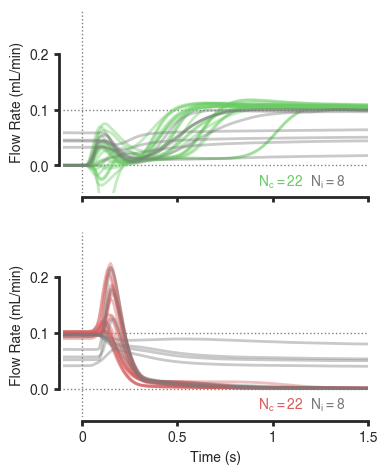

In [54]:
incomplete_transitions_dict = {
    'right': [19, 20],
    'middle': [17, 18],
    'left': [15, 16, 29, 30]}
    
COLOR_FLAG_CN = 'color-flag'

COLOR_FLAG_CATEGORY = pd.CategoricalDtype(
    categories=['OK-ON', 'OK-OFF', 'INCOMPLETE'],
    ordered=False)

def map_color_flag_gen(incomplete_transitions: list[int]) -> callable:    
    
    def map_color_flag(row_tuple: tuple[int, str]) -> str:
        transition_index, transition_type = row_tuple
        
        if transition_index in incomplete_transitions:
            return 'INCOMPLETE'
        else:
            if transition_type == ON_TRANSITION:
                return 'OK-ON'
            else:
                return 'OK-OFF'
            
    return map_color_flag

def figure_flow_on_off():
    side_selection = ['right', 'left', 'middle']
    filter_transition_df = transition_synched_flow_df.loc[
        (transition_synched_flow_df[MANIFOLD_POS_CN].isin(side_selection))
        & (transition_synched_flow_df[RUN_ID_CN] != 128)
        & (transition_synched_flow_df[TIME_CN] >= -0.4)
        & (transition_synched_flow_df[TIME_CN] <= 1.6),
        :]
    
    incomplete_transitions = []
    for s in side_selection:
        incomplete_transitions.extend(
            incomplete_transitions_dict[s])
        
    map_color_flag = map_color_flag_gen(incomplete_transitions)
    
    filter_transition_df[COLOR_FLAG_CN] = (
        filter_transition_df[[TRANSITION_INDEX_CN, TRANSITION_CN]]
        .apply(map_color_flag, axis=1)
        .astype(COLOR_FLAG_CATEGORY))
    
    fig = sns.relplot(
        data=filter_transition_df,
        x=TIME_CN,
        y=FLOW_RATE_CN,
        kind='line',
        row=TRANSITION_CN,
        row_order=[ON_TRANSITION, OFF_TRANSITION],
        style=TRANSITION_INDEX_CN,
        hue=COLOR_FLAG_CN,
        palette=color_palette,
        dashes=False,
        errorbar=('sd', 1),
        facet_kws={'sharey': False, 'sharex': True},
        legend=False,
        height=2.5,
        aspect=1.6,
        alpha=0.40,
        lw=2)
    
    def annotate(data, **kws):
        n_complete = (
            data.loc[
                data[COLOR_FLAG_CN] != 'INCOMPLETE', TRANSITION_INDEX_CN]
            .unique()
            .size)
        n_incomplete = (
            data[TRANSITION_INDEX_CN]
            .unique()
            .size 
            - n_complete)
                            
        complete_color = (
            color_palette[0]
            if (data[TRANSITION_CN].iloc[0] == ON_TRANSITION)
            else color_palette[1])
            
        ax = plt.gca()
        ax.text(.79, 0.04, 
                f'$\mathdefault{{N_c={n_complete}}}$', 
                transform=ax.transAxes,
                ha='right',
                color=complete_color)
        ax.text(.81, 0.04, 
                f'$\mathdefault{{N_i={n_incomplete}}}$', 
                transform=ax.transAxes,
                ha='left',
                color=color_palette[2])
    
    (fig
     .map(plt.axvline, x=0, color='k', linestyle=':', alpha= 0.5, zorder=0, lw=1)
     .map(plt.axhline, y=0, color='k', linestyle=':', alpha=0.5, zorder=0, lw=1)
     .map(plt.axhline, y=0.1, color='k', linestyle=':', alpha=0.5, zorder=0, lw=1)
     .map_dataframe(annotate)
     .set_axis_labels('Time (s)', 'Flow Rate (mL/min)')
     .set_titles('')
     .set(xticks=[0, 0.5, 1, 1.5], xlim=(-0.1, 1.5),
          yticks=[-0.1, 0, 0.1, 0.2, 0.3], ylim=(-0.05, 0.28)))
    
    fig.axes[0, 0].set(xticklabels=[])
    fig.axes[1, 0].set(
        xticklabels=['0', '0.5', '1', '1.5'])
    
    fig.despine(trim=True, offset=3)
    
    return fig.figure

%matplotlib inline
fig = figure_flow_on_off()
fig.set(facecolor='white')

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.


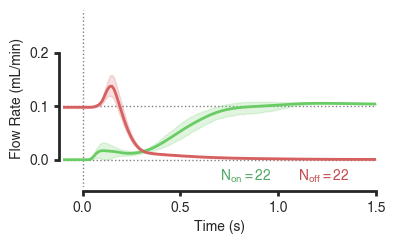

In [57]:
incomplete_transitions = []
[incomplete_transitions.extend(v) 
 for v in incomplete_transitions_dict.values()]

def figure_flow_agg():
    filter_transition_df = transition_synched_flow_df.loc[
         (~transition_synched_flow_df[TRANSITION_INDEX_CN]
          .isin(incomplete_transitions))
         & (transition_synched_flow_df[RUN_ID_CN] != 128)
         & (transition_synched_flow_df[TIME_CN] >= -0.4)
         & (transition_synched_flow_df[TIME_CN] <= 1.6), 
         :]
    
    fig = sns.relplot(
        data=filter_transition_df,
        x=TIME_CN,
        y=value_cn,
        hue=TRANSITION_CN,
        kind='line',
        hue_order=[ON_TRANSITION, OFF_TRANSITION],
        palette=sns.color_palette('muted')[2:4],
        errorbar=('ci', 95),
        n_boot=1000,
        alpha=1,
        lw=2,
        height=2.5,
        aspect=1.6,
        legend=False)
    
    ax = fig.axes[0, 0]
    n = np.unique(
        filter_transition_df
        .loc[(filter_transition_df[TRANSITION_CN] == ON_TRANSITION),
            TRANSITION_INDEX_CN]).size
    ax.text(.5, .035, f'$\mathdefault{{N_{{on}}={n}}}$', 
            transform=ax.transAxes,
            color=sns.color_palette('deep')[2])
    n = np.unique(
        filter_transition_df
        .loc[(filter_transition_df[TRANSITION_CN] == OFF_TRANSITION),
            TRANSITION_INDEX_CN]).size
    ax = fig.axes[0, 0]
    ax.text(.75, .035, f'$\mathdefault{{N_{{off}}={n}}}$', 
            transform=ax.transAxes,
            color=sns.color_palette('deep')[3])
    
    (fig
     .map(ax.axvline, x=0, color='k', linestyle=':', alpha= 0.5, zorder=0, lw=1)
     .map(ax.axhline, y=0, color='k', linestyle=':', alpha=0.5, zorder=0, lw=1)
     .map(ax.axhline, y=0.1, color='k', linestyle=':', alpha=0.5, zorder=0, lw=1)
     .set_titles('')
     .set(xlabel='Time (s)', ylabel='Flow Rate (mL/min)',
          xticks=[0, 0.5, 1, 1.5], xlim=(-0.1, 1.5),
          yticks=[0, 0.1, 0.2], ylim=(-0.05, 0.28))
     .despine(trim=True, offset=3))
    
    return fig.figure

%matplotlib inline
fig = figure_flow_agg()
fig.set(facecolor='white')
plt.show()

In [58]:
SUMMED_FLOW_RATE_CN = 'summed-flow-rate'

summed_flow_dfs = []
for transition_index in transition_synched_flow_df[TRANSITION_INDEX_CN].unique():
    filtered_df = transition_synched_flow_df.loc[
        transition_synched_flow_df[TRANSITION_INDEX_CN] == transition_index,
        :]
    
    pivot = filtered_df.pivot_table(
        columns=[TRANSITION_INDEX_CN,
                 MANIFOLD_POS_CN,  
                 STIM_TYPE_CN,
                 RUN_ID_CN, 
                 EXPERIMENT_ID_CN],
        index=TIME_CN,
        values=value_cn,
        aggfunc='sum')
    
    new_df = (
        pivot
        .melt(value_name=SUMMED_FLOW_RATE_CN, ignore_index=False)
        .reset_index())
    summed_flow_dfs.append(new_df)
    
multirun_synched_summed_flow_df = pd.concat(summed_flow_dfs, ignore_index=True)
    
multirun_synched_summed_flow_df.head()

time  transition-index manifold-pos stim-type  run-id experiment-id  \
0 -2.00                 1         left     pulse     128      cs-ii-31   
1 -1.99                 1         left     pulse     128      cs-ii-31   
2 -1.98                 1         left     pulse     128      cs-ii-31   
3 -1.97                 1         left     pulse     128      cs-ii-31   
4 -1.96                 1         left     pulse     128      cs-ii-31   

   summed-flow-rate  
0          0.043001  
1          0.043051  
2          0.043091  
3          0.043120  
4          0.043140

## Net Flow Rate Figure

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.


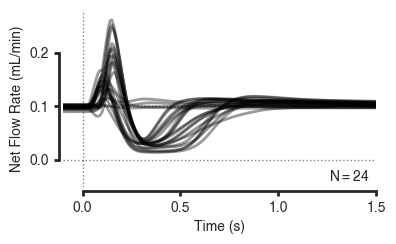

In [59]:
def figure_net_flow():
    filter_transition_df = multirun_synched_summed_flow_df.loc[
         (transition_synched_flow_df[RUN_ID_CN] != 128)
         & (transition_synched_flow_df[TIME_CN] >= -0.4)
         & (transition_synched_flow_df[TIME_CN] <= 1.6), 
         :]
    
    fig = sns.relplot(
        data=filter_transition_df,
        x=TIME_CN,
        y=SUMMED_FLOW_RATE_CN,
        style=TRANSITION_INDEX_CN,
        kind='line',
        color='k',
        dashes=False,
        alpha=0.4,
        lw=2,
        height=2.5,
        aspect=1.6,
        legend=False)
    
    ax = fig.axes[0, 0]
    n = np.unique(filter_transition_df[TRANSITION_INDEX_CN]).size
    ax.text(.85, .035, f'$\mathdefault{{N={n}}}$', 
            transform=ax.transAxes)
    
    (fig
     .map(ax.axvline, x=0, color='k', linestyle=':', alpha= 0.5, zorder=0, lw=1)
     .map(ax.axhline, y=0, color='k', linestyle=':', alpha=0.5, zorder=0, lw=1)
     .map(ax.axhline, y=0.1, color='k', linestyle=':', alpha=0.5, zorder=0, lw=1)
     .set(xlabel='Time (s)', ylabel='Net Flow Rate (mL/min)',
          xticks=[0, 0.5, 1, 1.5], xlim=(-0.1, 1.5),
          yticks=[0, 0.1, 0.2, 0.3], ylim=(-0.05, 0.28))
     .despine(trim=True, offset=3))
    
    return fig.figure

%matplotlib inline
fig = figure_net_flow()
fig.set(facecolor='white')
plt.show()

In [60]:
iterator = it.product(
    transition_synched_flow_df[TRANSITION_INDEX_CN].unique(),
    [ON_TRANSITION, OFF_TRANSITION])

samples_locs = [-0.2, 0, 0.2, 0.4, 0.7, 1, 1.3]
samples_locs_names = [f'{v:+.1f} sec' for v in samples_locs]
sample_width_sec = 0.07
sample_half_width_sec = sample_width_sec / 2

SAMPLE_TIME_CN = 'sample-time'

sub_dfs = []
for transition_index, transition_type in iterator:
    filter_transition_df = transition_synched_flow_df.loc[
        (transition_synched_flow_df[TRANSITION_INDEX_CN] == transition_index)
        & (transition_synched_flow_df[TRANSITION_CN] == transition_type),
        :]
    
    filter_transition_df = filter_transition_df.set_index(TIME_CN)
    
    samples = []
    for loc in samples_locs:
        sample_df = filter_transition_df.loc[
            (loc-sample_half_width_sec):(loc+sample_half_width_sec),
            FLOW_RATE_CN]
        
        samples.append(sample_df.mean())
        
    new_subdf = pd.DataFrame(
        index = pd.Index(samples_locs_names, name=SAMPLE_TIME_CN),
        columns=filter_transition_df.columns)
    for col in filter_transition_df.columns:
        new_subdf[col] = filter_transition_df.reset_index().loc[0, col]
    new_subdf[FLOW_RATE_CN] = samples
    new_subdf = new_subdf.reset_index()
    sub_dfs.append(new_subdf)
    
transition_sample_synched_flow_df = pd.concat(sub_dfs, ignore_index=True)

log.info(f'{transition_sample_synched_flow_df.shape = }')
transition_sample_synched_flow_df.head()

local-nb_cs-ii-31_dye-test-analysis (  40): INFO : transition_sample_synched_flow_df.shape = (504, 10)


sample-time transition-type manifold-pos odorant stim-type  sensor-id  \
0    -0.2 sec              on         left     dye     pulse          4   
1    +0.0 sec              on         left     dye     pulse          4   
2    +0.2 sec              on         left     dye     pulse          4   
3    +0.4 sec              on         left     dye     pulse          4   
4    +0.7 sec              on         left     dye     pulse          4   

   run-id experiment-id  flow-rate-mlpm  transition-index  
0     128      cs-ii-31       -0.000098                 1  
1     128      cs-ii-31       -0.000088                 1  
2     128      cs-ii-31        0.014099                 1  
3     128      cs-ii-31       -0.008545                 1  
4     128      cs-ii-31        0.000504                 1

## Flow Transition Boxplots Figure

In [61]:
sns.color_palette('muted')

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [62]:
side_palette = sns.color_palette([
    muted_palette[i] for i in
    [0, 1, 6]])
side_palette

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882)]

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.


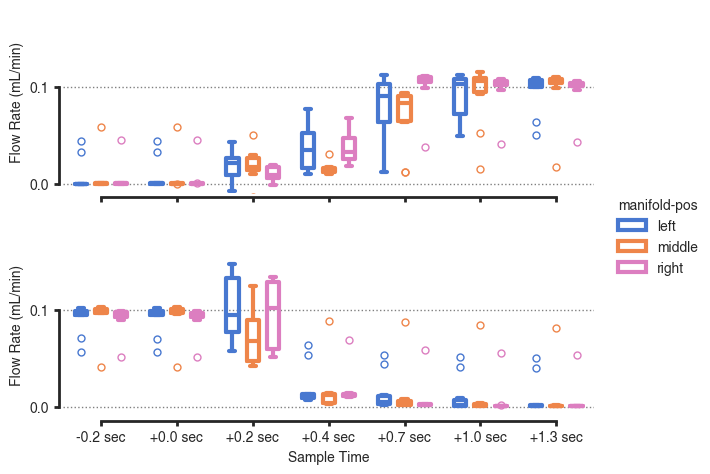

In [63]:

def figure_flow_transition_box():
    filter_transition_df = transition_sample_synched_flow_df.loc[
         (transition_sample_synched_flow_df[RUN_ID_CN] != 128), 
         :]
    
    fig = sns.catplot(
        data=filter_transition_df,
        x=SAMPLE_TIME_CN,
        y=FLOW_RATE_CN,
        hue=MANIFOLD_POS_CN,
        row=TRANSITION_CN,
        row_order=[ON_TRANSITION, OFF_TRANSITION],
        kind='box',
        palette=side_palette,
        height=2.5,
        aspect=2.5,
        legend=True,
        fill=False,
        linewidth=3,
        gap=0.4)
    
    (fig
     .refline(y=0, color='k', linestyle=':', alpha= 0.5, zorder=0, lw=1)
     .refline(y=0.1, color='k', linestyle=':', alpha=0.5, zorder=0, lw=1)
     .set_titles('')
     .set(xlabel='Sample Time', ylabel='Flow Rate (mL/min)',
          yticks=[0, 0.1], ylim=(-0.01, 0.18))
     .despine(trim=True, offset=3))
    
    return fig.figure

%matplotlib inline
fig = figure_flow_transition_box()
fig.set(facecolor='white')
plt.show()

In [64]:
sub_dfs = []
for transition_index in (
        multirun_synched_summed_flow_df[TRANSITION_INDEX_CN].unique()):
    filter_transition_df = multirun_synched_summed_flow_df.loc[
        (multirun_synched_summed_flow_df[TRANSITION_INDEX_CN] == transition_index),
        :]
    
    filter_transition_df = filter_transition_df.set_index(TIME_CN)
    
    samples = []
    for loc in samples_locs:
        sample_df = filter_transition_df.loc[
            (loc-sample_half_width_sec):(loc+sample_half_width_sec),
            SUMMED_FLOW_RATE_CN]        
        samples.append(sample_df.mean())
        
    new_subdf = pd.DataFrame(
        index = pd.Index(samples_locs_names, name=SAMPLE_TIME_CN),
        columns=filter_transition_df.columns)
    for col in filter_transition_df.columns:
        new_subdf[col] = filter_transition_df.reset_index().loc[0, col]
    new_subdf[SUMMED_FLOW_RATE_CN] = samples
    new_subdf = new_subdf.reset_index()
    sub_dfs.append(new_subdf)
    
transition_sample_synched_net_flow_df = pd.concat(sub_dfs, ignore_index=True)

log.info(f'{transition_sample_synched_net_flow_df.shape = }')
transition_sample_synched_net_flow_df.head()

local-nb_cs-ii-31_dye-test-analysis (  28): INFO : transition_sample_synched_net_flow_df.shape = (252, 7)


sample-time  transition-index manifold-pos stim-type  run-id experiment-id  \
0    -0.2 sec                 1         left     pulse     128      cs-ii-31   
1    +0.0 sec                 1         left     pulse     128      cs-ii-31   
2    +0.2 sec                 1         left     pulse     128      cs-ii-31   
3    +0.4 sec                 1         left     pulse     128      cs-ii-31   
4    +0.7 sec                 1         left     pulse     128      cs-ii-31   

   summed-flow-rate  
0          0.046211  
1          0.044275  
2          0.054607  
3          0.189001  
4          0.009139

## Net Flow Boxplots Figure

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.
local-nb_cs-ii-31_dye-test-analysis (   6): INFO : filter_transition_df.shape = (210, 7)


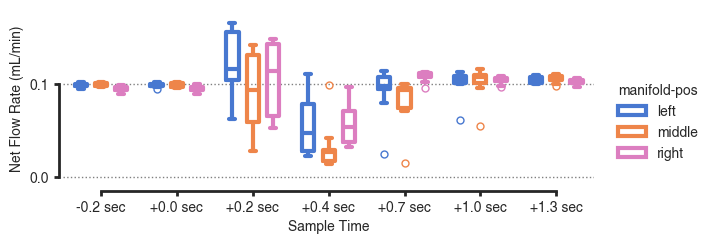

In [65]:
def figure_net_flow_box():
    filter_transition_df = transition_sample_synched_net_flow_df.loc[
         (transition_sample_synched_net_flow_df[RUN_ID_CN] != 128), 
         :]
    
    log.info(f'{filter_transition_df.shape = }')
    
    fig = sns.catplot(
        data=filter_transition_df,
        x=SAMPLE_TIME_CN,
        y=SUMMED_FLOW_RATE_CN,
        hue=MANIFOLD_POS_CN,
        kind='box',
        palette=side_palette,
        height=2.5,
        aspect=2.5,
        legend=True,
        gap=0.4,
        linewidth=3,
        fill=False)
    
    (fig
     .refline(y=0, color='k', linestyle=':', alpha= 0.5, zorder=0, lw=1)
     .refline(y=0.1, color='k', linestyle=':', alpha=0.5, zorder=0, lw=1)
     .set(xlabel='Sample Time', ylabel='Net Flow Rate (mL/min)',
          yticks=[0, 0.1], ylim=(-0.01, 0.18))
     .despine(trim=True, offset=3))
    
    return fig.figure

%matplotlib inline
fig = figure_net_flow_box()
fig.set(facecolor='white')
plt.show()

## Flow Rate On and Off Times Boxplot Figure

cutoff-type  time transition-type manifold-pos     odorant stim-type  \
0  $\pm.05$mL/min  1.00              on         left         dye     pulse   
1  $\pm.09$mL/min  1.11              on         left         dye     pulse   
2  $\pm.05$mL/min  0.24             off         left  fish-water     pulse   
3  $\pm.09$mL/min  0.97             off         left  fish-water     pulse   
4  $\pm.05$mL/min  0.33              on         left  fish-water     break   

   sensor-id  run-id experiment-id  transition-index  
0          4     129      cs-ii-31                 8  
1          4     129      cs-ii-31                 8  
2          2     129      cs-ii-31                 8  
3          2     129      cs-ii-31                 8  
4          2     129      cs-ii-31                 9

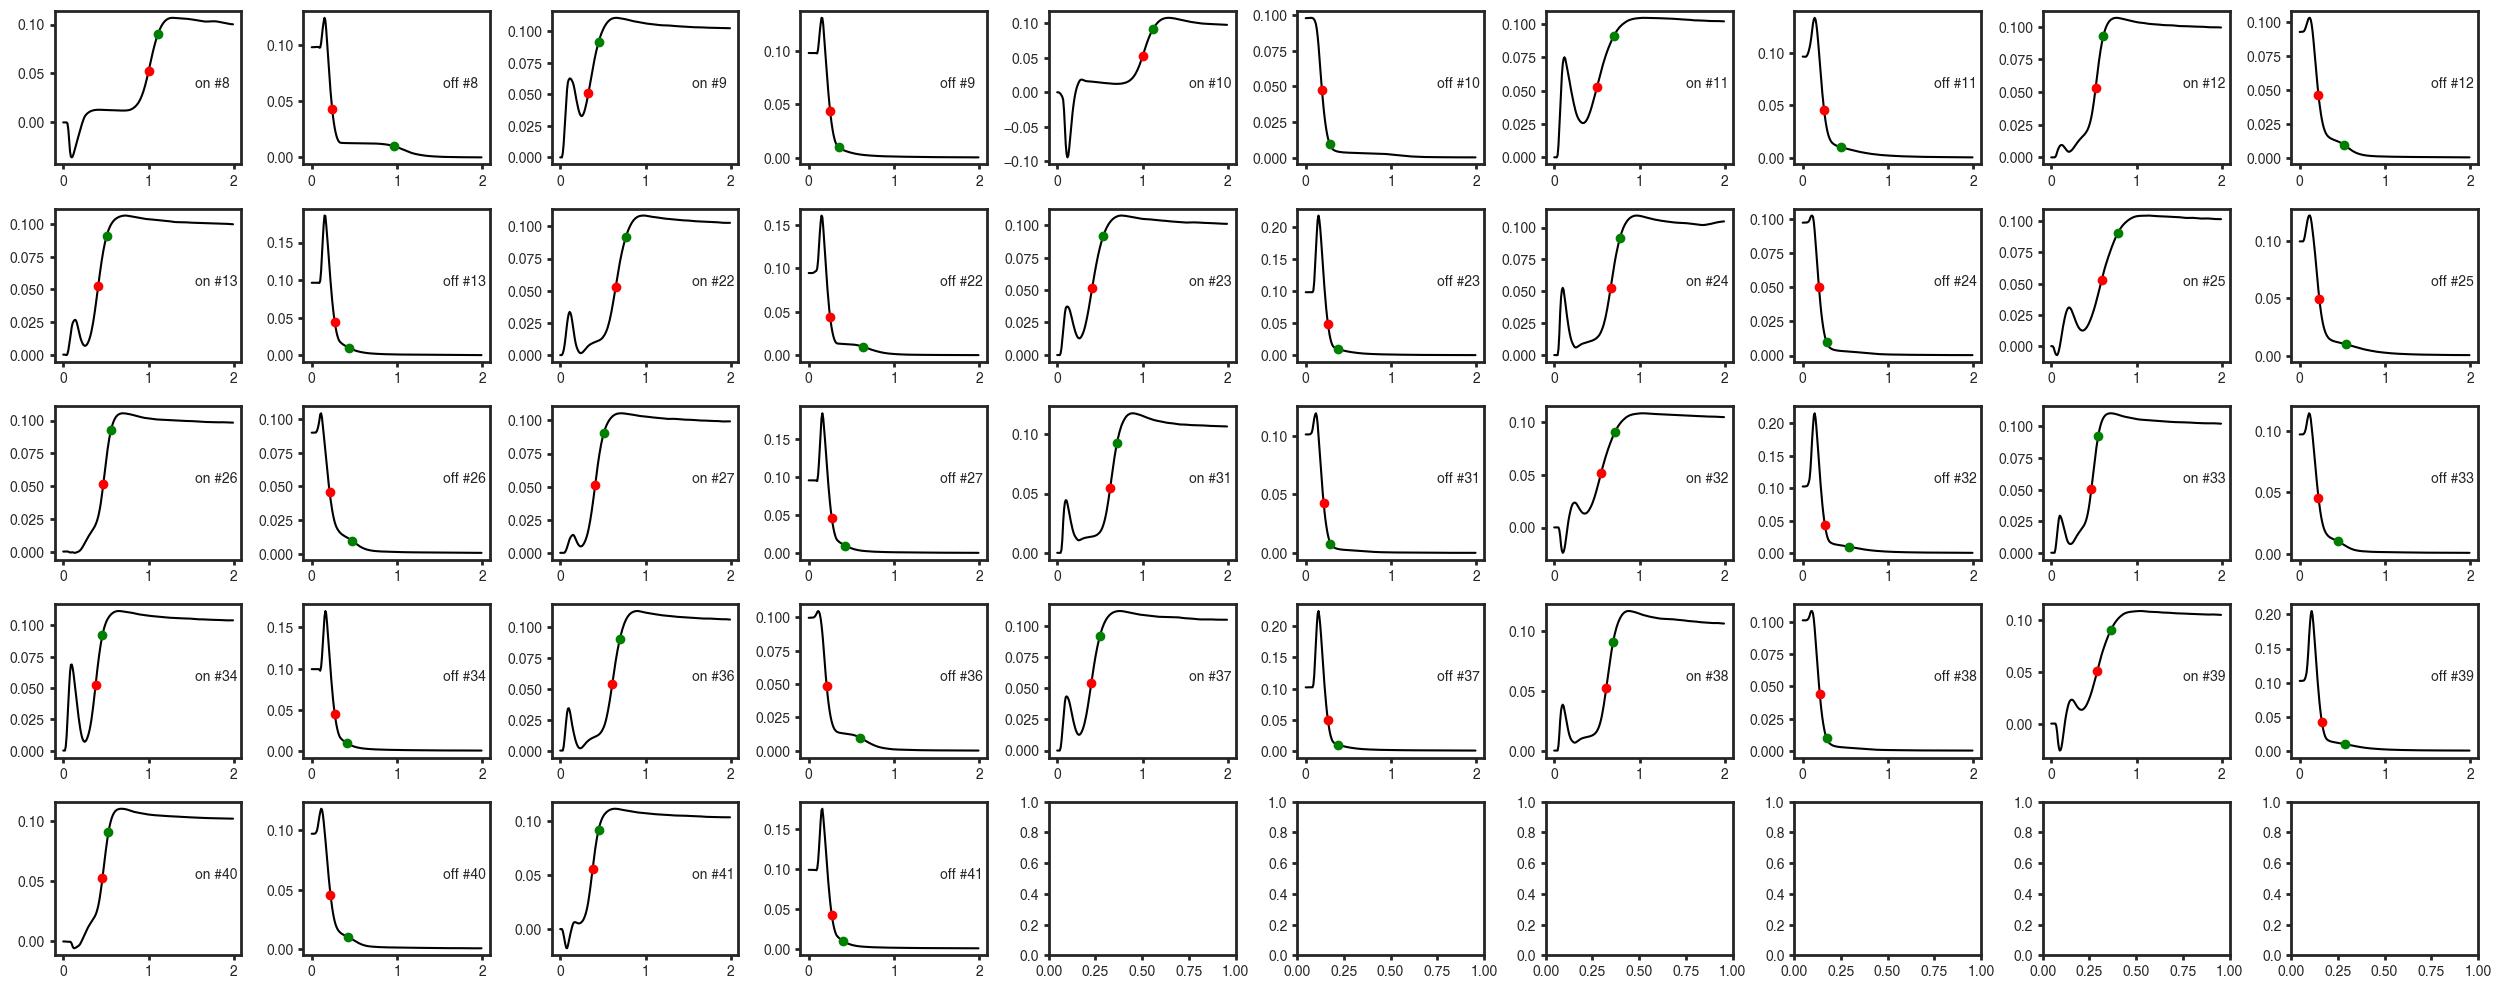

In [66]:
filter_transition_df = transition_synched_flow_df.loc[
     (~transition_synched_flow_df[TRANSITION_INDEX_CN]
      .isin(incomplete_transitions))
     & (transition_synched_flow_df[RUN_ID_CN] != 128)
     & (transition_synched_flow_df[TIME_CN] >= 0)
     & (transition_synched_flow_df[TIME_CN] <= 2), 
     :]

CUTOFF_TYPE_CN = 'cutoff-type'
on_off_time_dfs = []

iterator = it.product(
    filter_transition_df[TRANSITION_INDEX_CN].unique(),
    [ON_TRANSITION, OFF_TRANSITION])


on_t_cutoff_values = [0.05, 0.09]
off_t_cutoff_values = [0.05, 0.01]
cutoff_names = ['$\pm.05$mL/min', '$\pm.09$mL/min']
cutoff_names_index = pd.Index(cutoff_names, name=CUTOFF_TYPE_CN)

fig, axs = plt.subplots(
    5, 10, 
    squeeze=True,
    figsize=(25, 10))

for i, (transition_index, transition_type) in enumerate(iterator):
    sub_filter_df = filter_transition_df.loc[
        (filter_transition_df[TRANSITION_INDEX_CN] == transition_index)
        & (filter_transition_df[TRANSITION_CN] == transition_type),
        :]
    
    pivot = sub_filter_df.pivot(
        columns=[TRANSITION_INDEX_CN,
                 TRANSITION_CN],
        index=TIME_CN,
        values=FLOW_RATE_CN)
    
    is_on_transition = transition_type == ON_TRANSITION
    
    cutoff_values = (
        on_t_cutoff_values 
        if is_on_transition 
        else off_t_cutoff_values)
    
    on_off_time_df = (
        pd.DataFrame(
            index=cutoff_names_index,
            columns=sub_filter_df.columns)
        .drop(columns=[FLOW_RATE_CN, ]))
    for col in on_off_time_df.columns:
        on_off_time_df[col] = sub_filter_df.loc[sub_filter_df.index[0], col]
    ax = axs.flat[i]
    ax.text(0.75, 
            0.5, 
            f'{transition_type} #{transition_index}', 
            transform=ax.transAxes)
    ax.plot(pivot, color='k')
    for j, (cutoff_value, cutoff_name) in (
            enumerate(zip(cutoff_values, cutoff_names))):
        if is_on_transition:
            pivot_flag = pivot > cutoff_value
        else:
            pivot_flag = pivot < cutoff_value         
        
        pivot_flag = (
            pivot_flag
            .astype(int)
            .diff()
            .fillna(0)
            > 0)
        pivot_flag = pivot_flag.loc[pivot_flag.iloc[:, 0], :]
        pivot_flag = pivot_flag.iloc[-1:, :]        
        ax.plot(pivot.loc[pivot_flag.index, :], 
                linestyle=None, 
                marker='o', 
                color='r' if j== 0 else 'g')
        
        on_off_time_df.loc[cutoff_name, TIME_CN] = pivot_flag.index[0]
    
    on_off_time_dfs.append(on_off_time_df)
    
fig.tight_layout()

multirun_on_off_time_df = pd.concat(on_off_time_dfs).reset_index()

multirun_on_off_time_df.head()

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.


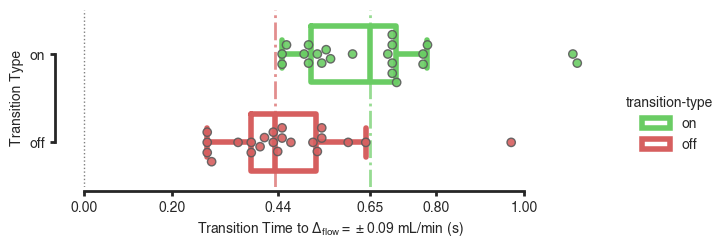

In [67]:
def figure_flow_on_off_box():
    filtered_on_off_df = multirun_on_off_time_df.loc[
        (multirun_on_off_time_df[CUTOFF_TYPE_CN] == cutoff_names[1]), 
        :]
    
    fig = sns.catplot(
        data=filtered_on_off_df,
        x=TIME_CN,
        y=TRANSITION_CN,
        hue=TRANSITION_CN,
        hue_order=[ON_TRANSITION, OFF_TRANSITION],
        kind='box',
        palette=sns.color_palette('muted')[2:4],
        height=2.5,
        aspect=2.5,
        legend=True,
        gap=0.2,
        fill=False,
        showfliers=False,
        linewidth=4)
    sns.swarmplot(
        data=filtered_on_off_df,
        x=TIME_CN,
        y=TRANSITION_CN,
        hue=TRANSITION_CN,
        palette=sns.color_palette('muted')[2:4],
        alpha=0.9,
        edgecolor='auto',
        linewidth=1,
        size=6)
    
    median_on_time = filtered_on_off_df.loc[
        filtered_on_off_df[TRANSITION_CN] == ON_TRANSITION, TIME_CN].median()
    median_off_time = filtered_on_off_df.loc[
        filtered_on_off_df[TRANSITION_CN] == OFF_TRANSITION, TIME_CN].median()
    
    (fig
     .refline(x=0, color='k', linestyle=':', alpha= 0.5, zorder=0, lw=1)
     .refline(x=median_on_time, color=sns.color_palette('muted')[2], 
              linestyle='-.', alpha= 0.7, zorder=0, lw=2)
     .refline(x=median_off_time, color=sns.color_palette('muted')[3], 
              linestyle='-.', alpha= 0.7, zorder=0, lw=2)
     .set(xlabel='Transition Time to $\mathdefault{\Delta_{flow}=\pm0.09}$ mL/min (s)', 
          ylabel='Transition Type',
          xticks=[0, 0.2, np.round(median_off_time, 2), 
                  np.round(median_on_time, 2), 0.8, 1.0])
     .despine(trim=True, offset=3))
    
    return fig.figure

%matplotlib inline
fig = figure_flow_on_off_box()
fig.set(facecolor='white')
plt.show()

## Save the Figures Out

In [68]:
all_figure_fcn = {
    'A': figure_flow_on_off,
    'B': figure_flow_agg,
    'C': figure_net_flow,
    'D': figure_flow_transition_box,
    'F': figure_net_flow_box,
    'E': figure_flow_on_off_box}

fig_output_dir = os.path.join(config_list[0].output_directory, 
                              'figures')

fig_name = 'zoss_validation_flow'
fig_output_subdir = os.path.join(fig_output_dir, fig_name)
csutils.touchdir(fig_output_subdir)

datetime_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

for fig_letter, fig_fcn in all_figure_fcn.items():
    fig = fig_fcn()
    plt.figtext(0.01, 0.99, fig_letter, 
                fontsize=20, 
                fontweight='900',
                ha='left', va='top')
    fig.savefig(os.path.join(
        fig_output_subdir, 
        f'{fig_name}-subfig-{fig_letter}_{datetime_stamp}.pdf'))
    plt.close(fig)

matplotlib.font_manager (1411): DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=900:stretch=normal:size=20.0.
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.525
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.24
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonU

# ZOSS Validation Output Figure

In [55]:
pre_stim_time_sec = 0.5
post_stim_time_sec = 10

time_index = pd.Index(
    np.arange(-pre_stim_time_sec, post_stim_time_sec, MASTER_DT), 
    name=TIME_CN)

TRANSITION_CN = 'transition-type'
TRANSITION_INDEX_CN = 'transition-index'
RELATIVE_SIGNAL_CN = 'relative-signal'
TRANSITION_SIDE_CN = 'transition-side'

value_cn = FLOW_RATE_CN

run_dfs = []
for row, stim_row in multirun_stim_config_df.iterrows():
    if stim_row[STIM_TYPE_CN] == 'equilibration':
        continue
        
    changed_lines = stim_row[LINES_CHANGED_CN]
    
    filtered_flow_df = multirun_flow_df.loc[
        (multirun_flow_df[RUN_ID_CN] == stim_row[RUN_ID_CN])
        & (multirun_flow_df[EXPERIMENT_ID_CN] == stim_row[EXPERIMENT_ID_CN])
        & multirun_flow_df[SENSOR_ID_CN].isin(changed_lines)
        & (multirun_flow_df[ODORANT_DESC_CN] == DYE_NAME),
        :]  
    filtered_flow_df = filtered_flow_df.reset_index()
    
    filtered_control_df = multirun_stim_control_df.loc[        
        (multirun_stim_control_df[RUN_ID_CN] == stim_row[RUN_ID_CN])
        & (multirun_stim_control_df[EXPERIMENT_ID_CN] == stim_row[EXPERIMENT_ID_CN])
        & multirun_stim_control_df[LINE_INDEX_CN].isin(changed_lines)
        & (multirun_stim_control_df[ODORANT_DESC_CN] == DYE_NAME),
        :] 
    filtered_control_df = filtered_control_df.reset_index()
    
    filtered_imaging_df = multirun_imaging_df.loc[
        (multirun_imaging_df[RUN_ID_CN] == stim_row[RUN_ID_CN])
        & (multirun_imaging_df[EXPERIMENT_ID_CN] == stim_row[EXPERIMENT_ID_CN]),
        :]
    filtered_imaging_df = filtered_imaging_df.reset_index()
    
    def get_on_off_status(line_index: int) -> str:
        if line_index in stim_row[TURN_ON_LINES_CN]:
            return ON_TRANSITION
        elif line_index in stim_row[TURN_OFF_LINES_CN]:
            return OFF_TRANSITION
        else:
            return NO_TRANSITION
        
    current_line = filtered_flow_df[SENSOR_ID_CN].unique()
    assert current_line.size == 1, (
        'Encountered more lines than expected after filtering')
    current_line = current_line[0]
    on_off_status = get_on_off_status(current_line)
    current_side = filtered_flow_df[MANIFOLD_POS_CN].unique()
    assert current_side.size == 1, (
        'Encountered more sides than expected after filtering')
    current_side = current_side[0]
    
    filtered_flow_df[TRANSITION_CN] = on_off_status
    filtered_control_df[TRANSITION_CN] = on_off_status
    filtered_imaging_df[TRANSITION_CN] = on_off_status
    
    filtered_control_df[REGION_KEY] = 'control-signal'
    filtered_control_df[SIDE_KEY] = filtered_control_df[MANIFOLD_POS_CN]
    filtered_control_df[TRANSITION_INDEX_CN] = row
    filtered_control_df[TRANSITION_SIDE_CN] = current_side
    
    filtered_flow_df[REGION_KEY] = 'flow-sensor'
    filtered_flow_df[SIDE_KEY] = filtered_flow_df[MANIFOLD_POS_CN]
    filtered_flow_df[TRANSITION_INDEX_CN] = row
    filtered_flow_df[TRANSITION_SIDE_CN] = current_side
    
    filtered_imaging_df[TRANSITION_INDEX_CN] = row
    filtered_imaging_df[TRANSITION_SIDE_CN] = current_side
    
    pivot_columns = [
        TRANSITION_CN,
        TRANSITION_SIDE_CN,
        REGION_KEY, 
        SIDE_KEY, 
        TRANSITION_INDEX_CN,
        RUN_ID_CN, 
        EXPERIMENT_ID_CN]
    
    flow_rate_pivot = filtered_flow_df.pivot(
        columns=pivot_columns,
        index=TIME_CN,
        values=RELATIVE_FLOW_RATE_CN)
    
    control_signal_pivot = filtered_control_df.pivot(
        columns=pivot_columns,
        index=TIME_CN,
        values=STIM_STATUS_CN)
    
    imaging_pivot = filtered_imaging_df.pivot(
        columns=pivot_columns,
        index=TIME_CN,
        values=FLUORESCENCE_KEY)
    
    master_pivot = pd.concat(
        [flow_rate_pivot, control_signal_pivot, imaging_pivot], 
        axis=1)
    
    transition_time = stim_row[ACTUAL_START_TIME_CN]
    sample_begin = transition_time - pre_stim_time_sec
    sample_end = transition_time + post_stim_time_sec
    
    master_pivot.index = master_pivot.index - transition_time
    master_pivot = master_pivot.reindex(time_index, method='nearest')
    
    master_subdf = (
        master_pivot
        .melt(value_name=RELATIVE_SIGNAL_CN, ignore_index=False)
        .reset_index())    
    
    run_dfs.append(master_subdf)
    
multirun_multimodality_signal_df = pd.concat(run_dfs, ignore_index=True)

log.info(f'{multirun_multimodality_signal_df.shape = }')
multirun_multimodality_signal_df.head() 

local-nb_cs-ii-31_dye-test-analysis ( 123): INFO : multirun_multimodality_signal_df.shape = (302400, 9)


time transition-type transition-side       region  side  transition-index  \
0 -0.50              on            left  flow-sensor  left                 1   
1 -0.49              on            left  flow-sensor  left                 1   
2 -0.48              on            left  flow-sensor  left                 1   
3 -0.47              on            left  flow-sensor  left                 1   
4 -0.46              on            left  flow-sensor  left                 1   

   run-id experiment-id  relative-signal  
0     128      cs-ii-31        -0.001861  
1     128      cs-ii-31        -0.001707  
2     128      cs-ii-31        -0.001512  
3     128      cs-ii-31        -0.001314  
4     128      cs-ii-31        -0.001126

## Transition Timecourse Across Modalities Figure

In [56]:
refline_kwargs = {
    'color': 'k', 
    'linestyle': ':', 
    'alpha': 0.5, 
    'zorder': 0,
    'lw': 1}
simple_refline = ft.partial(sns.FacetGrid.refline, **refline_kwargs)

In [57]:
sns.color_palette('muted')

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [58]:
def multi_mode_transition_subfig():
    incomplete_transitions = []
    [incomplete_transitions.extend(v) 
     for v in incomplete_transitions_dict.values()]
    
    region_palette = sns.color_palette(
        [sns.color_palette('muted')[i]
         for i in [7, 4, 9, 8]])
    
    hue_order = [
        'control-signal',
        'flow-sensor',
        'needle_outlet',
        'olfactory_epithelium']
    
    fig_filtered_df = multirun_multimodality_signal_df.loc[
        (multirun_multimodality_signal_df[TRANSITION_SIDE_CN] 
         == multirun_multimodality_signal_df[SIDE_KEY])
        & (multirun_multimodality_signal_df[RUN_ID_CN] != 128),
        :]
    
    facet_grid = sns.relplot(
        data=fig_filtered_df,
        x=TIME_CN,
        y=RELATIVE_SIGNAL_CN,
        kind='line',
        hue=REGION_KEY,
        hue_order=hue_order,
        row=TRANSITION_CN,
        palette=region_palette,
        errorbar=('ci', 95),
        n_boot=1000,
        facet_kws={'sharey': False, 'sharex': True},
        lw=2.5,
        height=2.5,
        aspect=1.7,
        alpha=1)
    
    (facet_grid
     .refline(x=0, **refline_kwargs)
     .refline(y=0, **refline_kwargs)
     .refline(y=1, **refline_kwargs)
     .set(xlabel='Time (s)', 
          ylabel='Relative Flow/Signal (%)',
          yticks=[0, 1],
          yticklabels=['0', '100'],
          xlim=(-0.5, 10),
          ylim=(-0.2, 1.2))
     .despine(trim=True, offset=3));
    
    return facet_grid.figure

## Transition On Off Boxplot Figure

cutoff-type          time transition-type transition-side  \
0         50%  1.010000e+00              on            left   
1         50%  4.440892e-16              on            left   
2         50%  4.650000e+00              on            left   
3         50%  5.510000e+00              on            left   
4         50%  2.400000e-01             off            left   

                 region  side  transition-index  run-id experiment-id  
0           flow-sensor  left                 8     129      cs-ii-31  
1        control-signal  left                 8     129      cs-ii-31  
2         needle_outlet  left                 8     129      cs-ii-31  
3  olfactory_epithelium  left                 8     129      cs-ii-31  
4           flow-sensor  left                 9     129      cs-ii-31

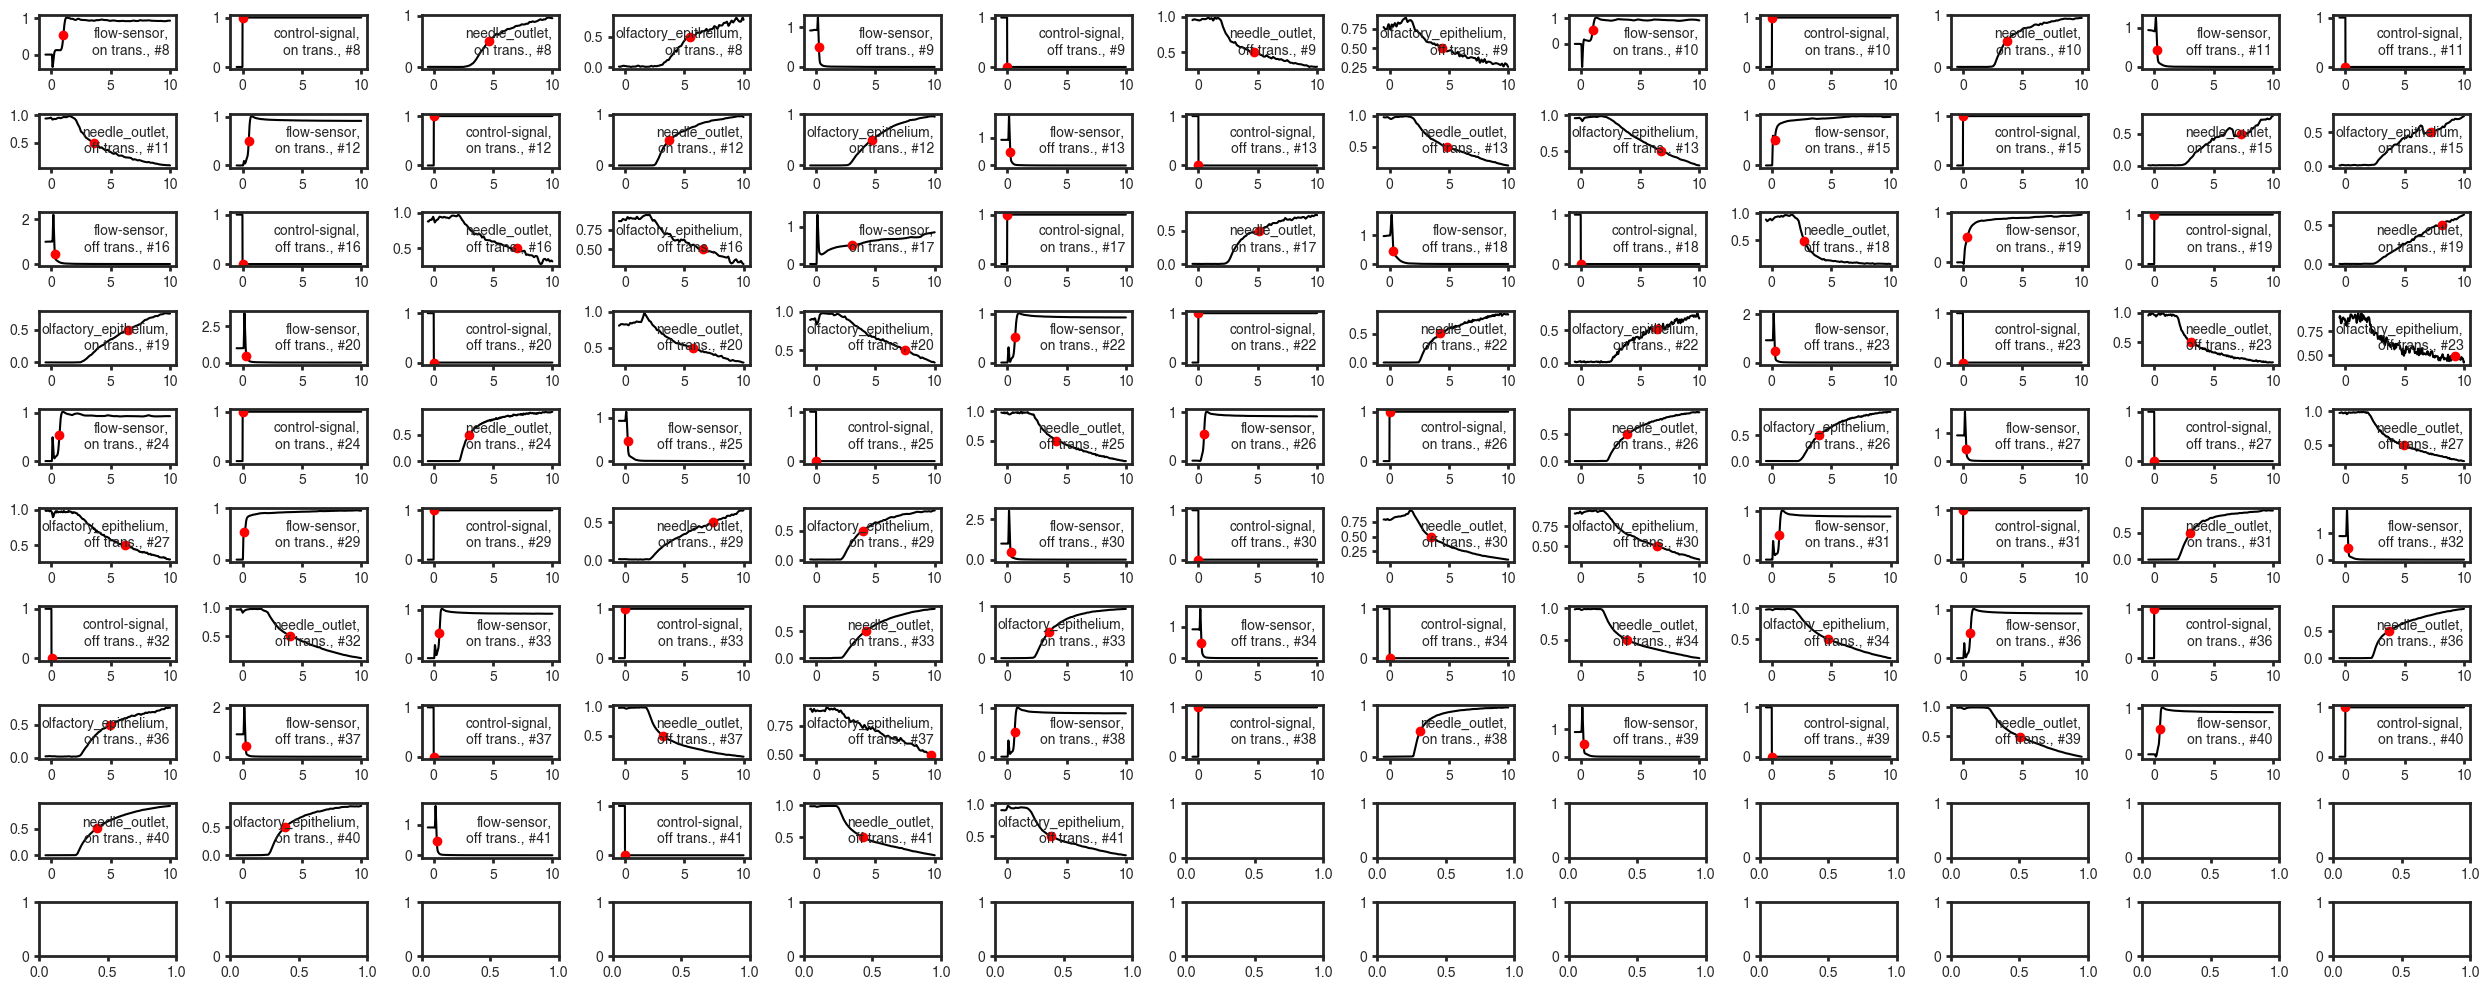

In [59]:
filtered_df = multirun_multimodality_signal_df.loc[
    (multirun_multimodality_signal_df[TRANSITION_SIDE_CN] 
     == multirun_multimodality_signal_df[SIDE_KEY])
    & (multirun_multimodality_signal_df[RUN_ID_CN] != 128),
    :]

CUTOFF_TYPE_CN = 'cutoff-type'
on_off_time_dfs = []

iterator = it.product(
    filtered_df[TRANSITION_INDEX_CN].unique(),
    [ON_TRANSITION, OFF_TRANSITION])


on_t_cutoff_values = [0.5, ]
off_t_cutoff_values = [0.5, ]
cutoff_names = ['50%', ]
cutoff_names_index = pd.Index(cutoff_names, name=CUTOFF_TYPE_CN)

fig, axs = plt.subplots(
    10, 13, 
    squeeze=True,
    figsize=(25, 10))
axcount = 0

for i, (transition_index, transition_type) in enumerate(iterator):
    sub_filter_df = filtered_df.loc[
        (filtered_df[TRANSITION_INDEX_CN] == transition_index)
        & (filtered_df[TRANSITION_CN] == transition_type),
        :]
    
    is_on_transition = (transition_type == ON_TRANSITION)
    cutoff_values = (
        on_t_cutoff_values 
        if is_on_transition 
        else off_t_cutoff_values)
    
    for region in sub_filter_df[REGION_KEY].unique():    
        sub_sub_filter_df = sub_filter_df.loc[
            (sub_filter_df[REGION_KEY] == region), :]
        
        pivot = (
            sub_sub_filter_df
            .pivot(
                columns=[TRANSITION_INDEX_CN,
                         TRANSITION_CN,
                         REGION_KEY],
                index=TIME_CN,
                values=RELATIVE_SIGNAL_CN))                              
        
        on_off_time_df = (
            pd.DataFrame(
                index=cutoff_names_index,
                columns=sub_sub_filter_df.columns)
            .drop(columns=[RELATIVE_SIGNAL_CN, ]))
        
        for col in on_off_time_df.columns:
            on_off_time_df[col] = (
                sub_sub_filter_df.loc[sub_sub_filter_df.index[0], col])
        ax = axs.flat[axcount]
        axcount += 1
        ax.text(0.95, 
                0.5, 
                f'{region},\n{transition_type} trans., #{transition_index}', 
                transform=ax.transAxes,
                ha='right',
                va='center')
        ax.plot(pivot, color='k')
        for j, (cutoff_value, cutoff_name) in (
                enumerate(zip(cutoff_values, cutoff_names))):
            if is_on_transition:
                pivot_flag = pivot > cutoff_value
            else:
                pivot_flag = pivot < cutoff_value         
            
            pivot_flag = (
                pivot_flag
                .astype(int)
                .diff()
                .fillna(0)
                > 0)
            pivot_flag = pivot_flag.loc[pivot_flag.iloc[:, 0], :]
            pivot_flag = pivot_flag.iloc[-1:, :]        
            ax.plot(pivot.loc[pivot_flag.index, :], 
                    linestyle=None, 
                    marker='o', 
                    color='r' if j == 0 else 'g')
            
            on_off_time_df.loc[cutoff_name, TIME_CN] = pivot_flag.index[0]
            
        on_off_time_dfs.append(on_off_time_df)
    
fig.tight_layout()

# raise RuntimeError('Breakpoint')

multirun_on_off_time_df = pd.concat(on_off_time_dfs).reset_index()
multirun_on_off_time_df.head()

In [62]:
def region_on_off_time_box():
    filtered_on_off_df = multirun_on_off_time_df.copy()

    palette = sns.color_palette(
        [sns.color_palette('muted')[i]
         for i in [7, 1, 0, 4]])
    
    hue_order = [
        'control-signal',
        'flow-sensor',
        'needle_outlet',
        'olfactory_epithelium']
    
    facet_grid = sns.catplot(
        data=filtered_on_off_df,
        x=TIME_CN,
        y=TRANSITION_CN,
        hue=REGION_KEY,
        hue_order=hue_order,
        kind='box',
        palette=palette,
        height=4.8,
        aspect=1,
        legend=True,
        fill=False,
        linewidth=4,
        gap=0.2)
    
    (facet_grid
     .refline(x=0, **refline_kwargs)
     .set(xlabel='Transition Time to 50% (s)', 
          ylabel='Transition Type')
     .despine(trim=True, offset=3))
    
    return facet_grid.figure

In [63]:
(multirun_on_off_time_df
 .groupby([CUTOFF_TYPE_CN, TRANSITION_CN, REGION_KEY])
 .agg({TIME_CN: ['median']}))

time
                                                        median
cutoff-type transition-type region                            
50%         off             control-signal        1.000000e-02
                            flow-sensor           2.600000e-01
                            needle_outlet         4.030000e+00
                            olfactory_epithelium  6.510000e+00
            on              control-signal        4.440892e-16
                            flow-sensor           6.200000e-01
                            needle_outlet         3.910000e+00
                            olfactory_epithelium  4.810000e+00

## Correlation Matrix

In [64]:
multirun_imaging_df.head()

time experiment-id  run-id    location_name  side         region  \
0 -4.00      cs-ii-31     128  LEFT-STIM (TOP)  left  needle_outlet   
1 -3.99      cs-ii-31     128  LEFT-STIM (TOP)  left  needle_outlet   
2 -3.98      cs-ii-31     128  LEFT-STIM (TOP)  left  needle_outlet   
3 -3.97      cs-ii-31     128  LEFT-STIM (TOP)  left  needle_outlet   
4 -3.96      cs-ii-31     128  LEFT-STIM (TOP)  left  needle_outlet   

   relative_fluorescence odorant  
0               0.001326     dye  
1               0.001326     dye  
2               0.001326     dye  
3               0.001326     dye  
4               0.001326     dye

In [65]:
DATA_SOURCE_CN = 'data-source'

corr_flow_df = multirun_flow_df.copy()
corr_ctrl_df = multirun_stim_control_df.copy()
corr_img_df = multirun_imaging_df.copy()

corr_flow_df = corr_flow_df.loc[
    (corr_flow_df[ODORANT_DESC_CN] == DYE_NAME), :]
corr_ctrl_df = corr_ctrl_df.loc[
    (corr_ctrl_df[ODORANT_DESC_CN] == DYE_NAME), :]

corr_flow_df[REGION_KEY] = (
    corr_flow_df[MANIFOLD_POS_CN]
    .apply(lambda x: f'{x}-flow'))

corr_ctrl_df[REGION_KEY] = (
    corr_ctrl_df[MANIFOLD_POS_CN]
    .apply(lambda x: f'{x}-ctrl'))

corr_img_df[REGION_KEY] = (
    corr_img_df[[SIDE_KEY, REGION_KEY]]
    .replace('needle_outlet', 'needle-outlet')
    .replace('olfactory_epithelium', 'olfactory-epithelium')
    .apply(lambda x: x[0] + '-' + x[1], axis=1)
    .replace('background-background', 'background'))

corr_flow_df = (corr_flow_df
   .rename(columns={RELATIVE_FLOW_RATE_CN: RELATIVE_SIGNAL_CN}))
corr_ctrl_df = (corr_ctrl_df
    .rename(columns={STIM_STATUS_CN: RELATIVE_SIGNAL_CN}))
corr_img_df = (corr_img_df
    .rename(columns={FLUORESCENCE_KEY: RELATIVE_SIGNAL_CN}))

corr_flow_df[DATA_SOURCE_CN] = 'flow'
corr_ctrl_df[DATA_SOURCE_CN] = 'control'
corr_img_df[DATA_SOURCE_CN] = 'imaging'

kept_columns = [
    TIME_CN,
    RELATIVE_SIGNAL_CN,
    REGION_KEY,
    DATA_SOURCE_CN,
    RUN_ID_CN,
    EXPERIMENT_ID_CN]

corr_ctrl_df = corr_ctrl_df.loc[:, kept_columns]
corr_flow_df = corr_flow_df.loc[:, kept_columns]
corr_img_df = corr_img_df.loc[:, kept_columns]

corr_df = pd.concat([corr_flow_df, corr_ctrl_df, corr_img_df], 
                    ignore_index=True)
corr_df = corr_df.loc[
    corr_df[TIME_CN].between(10, 290), :]

corr_df.info()
corr_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2016000 entries, 1401 to 2209100
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   time             float64
 1   relative-signal  float64
 2   region           object 
 3   data-source      object 
 4   run-id           int64  
 5   experiment-id    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 107.7+ MB


time  relative-signal      region data-source  run-id experiment-id
1401  10.01         0.001150  right-flow        flow     128      cs-ii-31
1402  10.02         0.001233  right-flow        flow     128      cs-ii-31
1403  10.03         0.001333  right-flow        flow     128      cs-ii-31
1404  10.04         0.001444  right-flow        flow     128      cs-ii-31
1405  10.05         0.001561  right-flow        flow     128      cs-ii-31

In [66]:
COR_REGION_CATEGORIES = [
    'left-ctrl',
    'left-flow',
    'left-needle-outlet',
    'left-olfactory-epithelium',
    'middle-ctrl',
    'middle-flow',
    'middle-needle-outlet',
    'right-ctrl',
    'right-flow',
    'right-needle-outlet',
    'right-olfactory-epithelium',
    'background']

CORR_REGION_SHORT_NAMES = [
    'LC', 'LF', 'LN', 'LOE',
    'MC', 'MF', 'MN',
    'RC', 'RF', 'RN', 'ROE',
    'B']

CORR_REGION_CAT_DTYPE = pd.CategoricalDtype(
    categories=COR_REGION_CATEGORIES, ordered=True)

corr_df[REGION_KEY] = (
    corr_df[REGION_KEY]
    .astype(CORR_REGION_CAT_DTYPE))

corr_df[REGION_KEY].unique()

['right-flow', 'left-flow', 'middle-flow', 'right-ctrl', 'left-ctrl', ..., 'middle-needle-outlet', 'right-needle-outlet', 'left-olfactory-epithelium', 'right-olfactory-epithelium', 'background']
Length: 12
Categories (12, object): ['left-ctrl' < 'left-flow' < 'left-needle-outlet' < 'left-olfactory-epithelium' ... 'right-flow' < 'right-needle-outlet' < 'right-olfactory-epithelium' < 'background']

In [67]:
run_iter = it.product(
    corr_df[RUN_ID_CN].unique(),
    corr_df[EXPERIMENT_ID_CN].unique())

corr_matrix_template = pd.DataFrame(
    index=COR_REGION_CATEGORIES,
    columns=COR_REGION_CATEGORIES)

corr_matrices = []

for run_id, experiment_id in run_iter:
    run_df = corr_df.loc[
        (corr_df[RUN_ID_CN] == run_id)
        & (corr_df[EXPERIMENT_ID_CN] == experiment_id), :]
    
    run_df = run_df.pivot(
        columns=[REGION_KEY],
        index=TIME_CN,
        values=RELATIVE_SIGNAL_CN)
    
    run_corr = run_df.corr()
    
    corr_matrix = corr_matrix_template.copy()
    corr_matrix.loc[run_corr.index, run_corr.columns] = run_corr.values
    corr_matrices.append(corr_matrix)

In [68]:
multirun_corr_matrix = (
    pd.concat(corr_matrices)
    .groupby(level=0)
    .mean()
    .reindex(COR_REGION_CATEGORIES, axis=0))

multirun_corr_matrix

left-ctrl  left-flow  left-needle-outlet  \
left-ctrl                    1.000000   0.948183            0.548417   
left-flow                    0.948183   1.000000            0.592287   
left-needle-outlet           0.548417   0.592287            1.000000   
left-olfactory-epithelium    0.474386   0.516514            0.939484   
middle-ctrl                 -0.050088  -0.049414           -0.057661   
middle-flow                 -0.049042  -0.048445           -0.056042   
middle-needle-outlet        -0.062107  -0.060072           -0.063578   
right-ctrl                  -0.050091  -0.049379           -0.064976   
right-flow                  -0.049729  -0.049028           -0.064030   
right-needle-outlet         -0.068599  -0.067120           -0.074724   
right-olfactory-epithelium  -0.067079  -0.065061           -0.070608   
background                   0.134569   0.153658            0.501461   

                            left-olfactory-epithelium  middle-ctrl  \
left-ctrl                                    0.474386    -0.050088   
left-flow                                    0.516514    -0.049414   
left-needle-outlet                           0.939484    -0.057661   
left-olfactory-epithelium                    1.000000    -0.034474   
middle-ctrl                                 -0.034474     1.000000   
middle-flow                                 -0.031714     0.937793   
middle-needle-outlet                        -0.030696     0.637700   
right-ctrl                                  -0.076137    -0.050091   
right-flow                                  -0.074267    -0.049640   
right-needle-outlet                         -0.088650    -0.072133   
right-olfactory-epithelium                  -0.069019    -0.022698   
background                                   0.619590     0.043730   

                            middle-flow  middle-needle-outlet  right-ctrl  \
left-ctrl                     -0.049042             -0.062107   -0.050091   
left-flow                     -0.048445             -0.060072   -0.049379   
left-needle-outlet            -0.056042             -0.063578   -0.064976   
left-olfactory-epithelium     -0.031714             -0.030696   -0.076137   
middle-ctrl                    0.937793              0.637700   -0.050091   
middle-flow                    1.000000              0.695812   -0.049232   
middle-needle-outlet           0.695812              1.000000   -0.039805   
right-ctrl                    -0.049232             -0.039805    1.000000   
right-flow                    -0.048819             -0.035432    0.959936   
right-needle-outlet           -0.068212              0.031453    0.582991   
right-olfactory-epithelium    -0.018715              0.081394    0.554085   
background                     0.059057              0.194633   -0.160611   

                            right-flow  right-needle-outlet  \
left-ctrl                    -0.049729            -0.068599   
left-flow                    -0.049028            -0.067120   
left-needle-outlet           -0.064030            -0.074724   
left-olfactory-epithelium    -0.074267            -0.088650   
middle-ctrl                  -0.049640            -0.072133   
middle-flow                  -0.048819            -0.068212   
middle-needle-outlet         -0.035432             0.031453   
right-ctrl                    0.959936             0.582991   
right-flow                    1.000000             0.620475   
right-needle-outlet           0.620475             1.000000   
right-olfactory-epithelium    0.589304             0.978499   
background                   -0.154024            -0.044370   

                            right-olfactory-epithelium  background  
left-ctrl                                    -0.067079    0.134569  
left-flow                                    -0.065061    0.153658  
left-needle-outlet                           -0.070608    0.501461  
left-olfactory-epithelium                    -0.069019    0.619590  
middle-ctrl  

In [69]:
def corr_matrix_subfig():
    corr_region_colors = sns.color_palette([
        sns.color_palette('muted', desat=1)[i]
        for i in ([0, ] * 4 + 
                  [1, ] * 3 + 
                  [6, ] * 4 + 
                  [7, ])])

    cmap = sns.color_palette('vlag', as_cmap=True)
    
    multirun_corr_matrix.index = CORR_REGION_SHORT_NAMES
    multirun_corr_matrix.columns = CORR_REGION_SHORT_NAMES
    cluster_grid = sns.clustermap(
        multirun_corr_matrix,  
        col_colors=corr_region_colors,
        row_colors=corr_region_colors,
        row_cluster=False,
        col_cluster=False,
        cmap=cmap, 
        center=0,
        vmax=1,
        linewidths=1,
        cbar_kws={'ticks': [-1, 0, 1]},
        figsize=(7, 7),
        cbar_pos=(.02, .32, .03, .2))
    
    ax = cluster_grid.ax_heatmap
    ax.tick_params(axis='y', labelrotation=0, length=0)
    ax.tick_params(axis='x', labelrotation=0, length=0)
    
    return cluster_grid.figure


## All Trial Plots

In [70]:
def all_trial_plots():
    # let's plot all the timecourses 
    filter_imaging_df = multirun_imaging_df.loc[
        ~(multirun_imaging_df[RUN_ID_CN].isin([127, 128, 129])),
        :]
    
    location_order = [
        'LEFT-STIM (TOP)',
        'LEFT-OE (TOP)',
        'MIDDLE-STIM',
        'RIGHT-STIM (BOTTOM)',
        'RIGHT-OE (BOTTOM)',
        'BACKGROUND']
    
    side_palette = sns.color_palette([
        muted_palette[i] for i in
        [0, 1, 6, 7]])
    
        
    facet_grid = sns.relplot(
        data=filter_imaging_df,
        x=TIME_KEY,
        y=FLUORESCENCE_KEY,
        hue=SIDE_KEY,
        palette=side_palette,
        kind='line',
        row=LOCATION_KEY,
        row_order=location_order,
        style=RUN_ID_CN,
        dashes=False,
        facet_kws={'sharey': False, 'sharex': True},
        height=1,
        aspect=4.5,
        linewidth=2,
        alpha=0.4)
    
    (facet_grid
     .refline(x=0, **refline_kwargs)
     .refline(y=0, **refline_kwargs)
     .refline(y=1, **refline_kwargs)
     .set_titles('')
     .set(xlabel='Time (s)', 
          ylabel='Relative Fluorescence (%)',
          yticks=[0, 1],
          xticks=[0, 30, 45, 120, 135, 210, 225, 300],
          xlim=(0, 300),
          ylim=(-0.05, 1.1),            
          yticklabels=['0', '100'])
     .despine(trim=True, offset=3))
    facet_grid.figure.subplots_adjust(wspace=0, hspace=0.1, left=0.1)
    
    for i, (row_name, ax) in (
            enumerate(facet_grid.axes_dict.items())):
        if i != 4:
            ax.set_ylabel('')
        
        row_name_lower = row_name.lower()
        if 'left' in row_name_lower:
            side_filt = 'left'
        elif 'right' in row_name_lower:
            side_filt = 'right'
        elif 'middle' in row_name_lower:
            side_filt = 'middle'
        else:
            continue
            
        control_seq = multirun_stim_control_df.loc[
            (multirun_stim_control_df[RUN_ID_CN] == 132)
            & (multirun_stim_control_df[ODORANT_DESC_CN] == DYE_NAME)
            & (multirun_stim_control_df[MANIFOLD_POS_CN] == side_filt), 
            :]
        
        control_seq = control_seq.pivot(
            columns=[MANIFOLD_POS_CN],
            index=TIME_CN,
            values=STIM_STATUS_CN)
        
        lower_bound = np.zeros(control_seq.shape[0]) - 1
        upper_bound = (control_seq.to_numpy().flatten() * 2) - 1
        x_values = control_seq.index.to_numpy()
        
        ax.fill_between(
            x_values, lower_bound, upper_bound, 
            color='k', alpha=0.2, zorder=0, lw=0)
        
    return facet_grid.figure
        

## Save the Figures Out

In [71]:
all_figure_fcn = {
    'A': multi_mode_transition_subfig,
    'B': region_on_off_time_box,
    'C': all_trial_plots,
    'D': corr_matrix_subfig,
}

fig_output_dir = os.path.join(config_list[0].output_directory, 
                              'figures')

fig_name = 'zoss_validation_outputs'
fig_output_subdir = os.path.join(fig_output_dir, fig_name)
csutils.touchdir(fig_output_subdir)

datetime_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

for fig_letter, fig_fcn in all_figure_fcn.items():
    fig = fig_fcn()
    plt.figtext(0.01, 0.99, fig_letter, 
                fontsize=20, 
                fontweight='900',
                ha='left', va='top')
    fig.savefig(os.path.join(
        fig_output_subdir, 
        f'{fig_name}-subfig-{fig_letter}_{datetime_stamp}.pdf'))
    plt.close(fig)

matplotlib.font_manager (1411): DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=900:stretch=normal:size=20.0.
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.525
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.24
matplotlib.font_manager (1423): DEBUG : findfont: score(FontEntry(fname='I:\\CorbanSwain\\repos\\zmia\\envs\\zmia-env-everything-3.10-v3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonU